# Comparación Final

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate
from statsmodels.tsa.arima_process import ArmaProcess
from sklearn.linear_model import Ridge
from scipy.stats import t
from scipy.linalg import svd, solve
from statsmodels.tsa.seasonal import seasonal_decompose
from bayes_opt import BayesianOptimization
import warnings
from scipy.stats import wasserstein_distance

try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    TORCH_AVAILABLE = True
except ImportError:
    TORCH_AVAILABLE = False
    print("PyTorch no está disponible. DeepAR funcionará en modo limitado.")

warnings.filterwarnings("ignore")


## Clases adicionales

### Simulador de series

In [69]:
class TimeSeriesSimulator:
    def __init__(self, phi, theta, noise_dist, sigma, n, burn_in):
        self.phi = phi
        self.theta = theta
        self.noise_dist = noise_dist
        self.sigma = sigma
        self.n = n
        self.burn_in = burn_in

    def generate_noise(self):
        """Genera ruido según la distribución especificada."""
        if self.noise_dist == 'normal':
            return np.random.normal(0, self.sigma, self.n)
        elif self.noise_dist == 'uniform':
            return np.random.uniform(-np.sqrt(3)*self.sigma, np.sqrt(3)*self.sigma, self.n)
        elif self.noise_dist == 'exponential':
            return np.random.exponential(scale=self.sigma, size=self.n) - self.sigma
        elif self.noise_dist == 't':
            return self.sigma * t.rvs(df=3, size=self.n)
        else:
            raise ValueError("Distribución no soportada")

    def simulate_arma(self, noise):
        """Simula una serie ARMA usando ruido predefinido."""
        arma = ArmaProcess(ar=np.r_[1, -np.array(self.phi)], ma=np.r_[1, self.theta])

        def noise_generator(size):
            return np.random.choice(noise, size=size, replace=True)

        series = arma.generate_sample(nsample=self.n, scale=1, distrvs=noise_generator)
        return series[self.burn_in:], noise[self.burn_in:]  # Serie y ruido limpio


### Simualción con cambios

In [70]:
from statsmodels.tsa.arima_process import ArmaProcess

class StructuralBreakSimulator:
    """Simulador de series con cambios estructurales"""
    
    def __init__(self, phi1, phi2, theta1, theta2, break_point, n, burn_in, noise_dist='normal', sigma=0.5):
        self.phi1 = phi1
        self.phi2 = phi2
        self.theta1 = theta1
        self.theta2 = theta2
        self.break_point = break_point
        self.n = n
        self.burn_in = burn_in
        self.noise_dist = noise_dist
        self.sigma = sigma

    def generate_noise(self):
        """Genera ruido según la distribución especificada"""
        if self.noise_dist == 'normal':
            return np.random.normal(0, self.sigma, self.n)
        elif self.noise_dist == 'uniform':
            return np.random.uniform(-self.sigma, self.sigma, self.n)
        elif self.noise_dist == 't':
            return self.sigma * np.random.standard_t(3, self.n)
        else:
            raise ValueError(f"Distribución no soportada: {self.noise_dist}")

    def simulate_with_break(self):
        """Genera serie con cambio estructural"""
        noise = self.generate_noise()
        
        # Primera parte de la serie
        arma1 = ArmaProcess(ar=np.r_[1, -np.array(self.phi1)], 
                          ma=np.r_[1, self.theta1])
        series1 = arma1.generate_sample(nsample=self.break_point, 
                                      scale=self.sigma)
        
        # Segunda parte de la serie
        arma2 = ArmaProcess(ar=np.r_[1, -np.array(self.phi2)], 
                          ma=np.r_[1, self.theta2])
        series2 = arma2.generate_sample(nsample=self.n - self.break_point, 
                                      scale=self.sigma)
        
        # Combinar series y aplicar burn-in
        full_series = np.concatenate([series1, series2])
        return full_series[self.burn_in:], noise[self.burn_in:]

### Plotting

In [71]:
class PlotManager:
    @staticmethod
    def plot_series(series, title="Serie Temporal Simulada"):
        import matplotlib.pyplot as plt
        plt.figure(figsize=(12, 5))
        plt.plot(series, label="Serie Simulada", color='#1f77b4', linewidth=1.2, alpha=0.8)
        plt.title(title, fontsize=14, pad=20)
        plt.xlabel("Tiempo", fontsize=12)
        plt.ylabel("Valor", fontsize=12)
        plt.grid(True, linestyle=':', alpha=0.6)
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def plot_all_distributions(real_noise, bootstrap_samples, cp_predictions, 
                             tdm_predictions, deepar_predictions, metrics, 
                             title="Comparación de Densidades Predictivas"):
        import matplotlib.pyplot as plt
        import seaborn as sns
        from scipy.stats import gaussian_kde
        
        plt.figure(figsize=(14, 7))
        
        # Configuración de colores y estilos
        colors = {
            'Real': '#d62728',        # Rojo
            'Bootstrap': '#ff7f0e',   # Naranja
            'CPnewModel': '#9467bd',  # Morado
            'TimeDistributionModel': '#2ca02c',  # Verde
            'DeepAR': '#17becf'       # Cyan
        }
        
        # Función mejorada para graficar densidades
        def plot_model_density(data, color, label):
            if len(data) < 2:
                return  # Evitar errores con pocos datos
            
            kde = gaussian_kde(data, bw_method=0.25)
            x = np.linspace(min(data), max(data), 500)
            y = kde(x)
            plt.plot(x, y, color=color, lw=2.5, alpha=0.9, label=label)
            plt.fill_between(x, y, color=color, alpha=0.15)

        # Graficar todas las densidades
        plot_model_density(real_noise, colors['Real'], 'Distribución Real')
        plot_model_density(bootstrap_samples, colors['Bootstrap'], 'Bootstrap')
        plot_model_density(cp_predictions, colors['CPnewModel'], 'CPnewModel')
        plot_model_density(tdm_predictions, colors['TimeDistributionModel'], 'TimeDistributionModel')
        plot_model_density(deepar_predictions, colors['DeepAR'], 'DeepAR')

        # Configurar leyenda
        leg = plt.legend(
            fontsize=12,
            frameon=True,
            framealpha=0.97,
            loc='upper left',  # Esquina superior derecha
            facecolor='white',
            edgecolor='#333333',
            borderpad=1,
            borderaxespad=0.5,
            labelspacing=0.8,
            handlelength=2,
            handleheight=1.5
        )
        leg.set_zorder(100)  # Asegurar que esté por encima de todo

        # Cuadro de métricas
        sorted_metrics = sorted(metrics.items(), key=lambda x: x[1]['Wasserstein'])
        text_str = "Distancias de Wasserstein:\n" + '\n'.join(
            [f"• {model}: {val['Wasserstein']:.4f}" for model, val in sorted_metrics]
        )
        
        plt.text(
            0.97, 0.97, text_str,
            transform=plt.gca().transAxes,
            verticalalignment='top',
            horizontalalignment='right',
            fontsize=11,
            bbox=dict(
                facecolor='white',
                alpha=0.97,
                edgecolor=colors['Real'],
                linewidth=1.5,
                boxstyle='round,pad=0.5'
            ),
            fontfamily='monospace',
            color='#333333',
            zorder=99  # Debajo de la leyenda
        )

        # Configuración final del gráfico
        plt.title(title, fontsize=16, pad=25, weight='bold', color='#2a2a2a')
        plt.xlabel("Valor", fontsize=13, labelpad=12)
        plt.ylabel("Densidad", fontsize=13, labelpad=12)
        plt.grid(True, linestyle=':', color='#aaaaaa', alpha=0.4)
        plt.xlim(np.percentile(real_noise, 0.5), np.percentile(real_noise, 99.5))
        plt.ylim(0, None)
        plt.gca().set_facecolor('#f8f8f8')
        plt.tight_layout()
        plt.show()

## Clases de los modelos

### Bootstrapping

In [72]:
import numpy as np
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg
from scipy.stats import wasserstein_distance

class BootstrappingModel:
    """Modelo para generar distribuciones predictivas usando bootstrapping"""
    
    def __init__(self, random_state=42):
        self.n_lags = None
        self.random_state = random_state
        self.model = None
        self.mean_val = None
        self.std_val = None

    def prepare_data(self, df):
        """Prepara los datos normalizando"""
        values = df['valor'].values
        self.mean_val = np.mean(values)
        self.std_val = np.std(values)
        return (values - self.mean_val) / self.std_val

    def denormalize(self, values):
        """Desnormaliza los valores para volver a la escala original"""
        return values * self.std_val + self.mean_val

    def fit_predict(self, df, n_boot=1000):
        """Ajusta el modelo y genera predicciones bootstrap"""
        normalized_values = self.prepare_data(df)
        
        # Ajustar modelo AutoReg
        self.model = AutoReg(normalized_values, lags=self.n_lags, old_names=False)
        fitted_model = self.model.fit()

        # Generar predicciones bootstrap
        predictions = fitted_model.forecast(steps=1)
        residuals = fitted_model.resid

        rng = np.random.default_rng(seed=self.random_state)
        boot_predictions = predictions + rng.choice(residuals, size=n_boot, replace=True)

        # Desnormalizar predicciones
        boot_predictions = self.denormalize(boot_predictions)

        return boot_predictions

    def calculate_wasserstein(self, distribution, real_noise):
        """Calcula la distancia de Wasserstein entre dos distribuciones"""
        return wasserstein_distance(distribution, real_noise)

    def grid_search(self, df, real_noise, lags_range=range(1, 13), n_boot=500):
        """Búsqueda en malla para encontrar el mejor n_lags usando Wasserstein"""
        best_distance = float('inf')
        best_lag = None

        for n_lags in lags_range:
            self.n_lags = n_lags
            try:
                # Generar distribución predictiva
                distribution = self.fit_predict(df, n_boot=n_boot)
                
                # Calcular distancia con el ruido real
                current_distance = self.calculate_wasserstein(distribution, real_noise)
                
                # Actualizar mejores parámetros
                if current_distance < best_distance:
                    best_distance = current_distance
                    best_lag = n_lags
                    
            except Exception as e:
                # Manejar posibles errores de ajuste del modelo
                continue

        self.n_lags = best_lag
        print(f"✅ Mejor n_lags encontrado: {self.n_lags} (Wasserstein = {best_distance:.4f})")
        return best_lag

### CPNewModel

In [73]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import Ridge
from bayes_opt import BayesianOptimization
from scipy.stats import wasserstein_distance

class CPnewModel:
    """Modelo avanzado para series temporales con optimización bayesiana (versión sin Numba)"""
    
    def __init__(self, n_lags=5, rho=0.95, max_points=10000, alpha=0.1, poly_degree=2, 
                 seasonal_periods=[12], random_state=42):
        self.n_lags = n_lags
        self.rho = rho
        self.max_points = max_points
        self.alpha = alpha
        self.poly_degree = poly_degree
        self.seasonal_periods = seasonal_periods
        self.mean_val = None
        self.std_val = None
        self.trends = []
        self.seasonalities = []
        self.random_state = random_state
        np.random.seed(self.random_state)

    def optimize_hyperparameters(self, df, real_noise):
        """
        Optimiza hiperparámetros usando Bayesian Optimization con Wasserstein
        """
        def objective(n_lags, rho, poly_degree):
            try:
                # Conversión y validación de parámetros
                n_lags_int = max(1, int(round(n_lags)))
                rho_bounded = min(0.999, max(0.5, float(rho)))
                poly_degree_int = max(1, int(round(poly_degree)))
                
                # Validar suficiencia de datos
                if len(df) <= n_lags_int * 2:
                    return -float('inf')
                
                # Configurar parámetros temporales
                self.n_lags = n_lags_int
                self.rho = rho_bounded
                self.poly_degree = poly_degree_int
                
                # Generar predicciones
                try:
                    predictions = self.fit_predict(df.copy())
                    
                    # Validar predicciones
                    if np.any(np.isnan(predictions)) or np.any(np.isinf(predictions)):
                        return -float('inf')
                    
                    # Calcular distancia de Wasserstein
                    w_dist = wasserstein_distance(predictions, real_noise)
                    
                    # Penalización por parámetros extremos
                    penalty = 0
                    if n_lags_int > 8:  # Penalizar lags muy grandes
                        penalty += 0.1 * (n_lags_int - 8)
                    if rho_bounded > 0.98:  # Penalizar rho muy cercano a 1
                        penalty += 0.1 * (rho_bounded - 0.98) / 0.019
                    
                    return -(w_dist + penalty)  # Minimizar distancia total
                    
                except Exception as e:
                    print(f"Error en iteración: {str(e)}")
                    return -float('inf')
                    
            except Exception:
                return -float('inf')

        # Configurar el optimizador bayesiano
        optimizer = BayesianOptimization(
            f=objective,
            pbounds={
                'n_lags': (1, 8),
                'rho': (0.7, 0.99),
                'poly_degree': (1, 3)
            },
            random_state=self.random_state,
            verbose=0
        )
        
        # Estrategia de optimización en dos fases
        best_score = -float('inf')
        
        # Fase 1: Exploración amplia
        optimizer.maximize(init_points=10, n_iter=15)
        
        # Fase 2: Búsqueda local
        if optimizer.max:
            best_params = optimizer.max['params']
            optimizer.set_bounds({
                'n_lags': (max(1, best_params['n_lags']-1), min(8, best_params['n_lags']+1)),
                'rho': (max(0.7, best_params['rho']-0.05), min(0.99, best_params['rho']+0.05)),
                'poly_degree': (max(1, best_params['poly_degree']-1), min(3, best_params['poly_degree']+1))
            })
            optimizer.maximize(init_points=5, n_iter=10)

        # Procesar resultados
        if optimizer.max and optimizer.max['target'] > -float('inf'):
            final_params = optimizer.max['params']
            best_wasserstein = -optimizer.max['target'] - final_params.get('penalty', 0)
            
            self.n_lags = max(1, int(round(final_params['n_lags'])))
            self.rho = min(0.999, max(0.5, final_params['rho']))
            self.poly_degree = max(1, int(round(final_params['poly_degree'])))
            
            print("✅ Optimización exitosa:")
            print(f"  • Lags: {self.n_lags}")
            print(f"  • Rho: {self.rho:.3f}")
            print(f"  • Grado polinomial: {self.poly_degree}")
            print(f"  • Distancia de Wasserstein: {best_wasserstein:.4f}")
        else:
            self.n_lags = 3
            self.rho = 0.85
            self.poly_degree = 2
            print("⚠️ Optimización fallida. Usando valores por defecto:")
            print(f"  • Lags: {self.n_lags}")
            print(f"  • Rho: {self.rho:.3f}")
            print(f"  • Grado polinomial: {self.poly_degree}")
        
        return self.n_lags, self.rho, self.poly_degree

    def decompose_series(self, df):
        """Elimina tendencia y estacionalidades usando numpy arrays"""
        values = df['valor'].values if isinstance(df, pd.DataFrame) else df
        residual = values.copy().astype(np.float64)

        self.trends = []
        self.seasonalities = []

        for period in self.seasonal_periods:
            if len(residual) >= 2 * period:
                result = seasonal_decompose(residual, period=period, model='additive', extrapolate_trend='freq')
                self.trends.append(result.trend.astype(np.float64))
                self.seasonalities.append(result.seasonal.astype(np.float64))
                residual -= np.nan_to_num(result.trend) + np.nan_to_num(result.seasonal)

        return np.nan_to_num(residual)

    def recombine_components(self, predictions):
        """Agrega componentes estructurales usando numpy"""
        trend_sum = sum(trend[-1] for trend in self.trends if trend is not None and len(trend) > 0)
        seasonal_sum = sum(season[-1] for season in self.seasonalities if season is not None and len(season) > 0)
        return predictions + trend_sum + seasonal_sum

    def _create_lag_matrix(self, values, n_lags, degree=2):
        """Crea matriz de rezagos con términos polinomiales (versión sin Numba)"""
        n = len(values) - n_lags
        X = np.ones((n, 1), dtype=np.float64)
        for lag in range(n_lags):
            lagged = values[lag:lag + n].reshape(-1, 1).astype(np.float64)
            X = np.hstack((X, lagged))
            if degree > 1:
                for d in range(2, degree + 1):
                    X = np.hstack((X, np.power(lagged, d)))
        return X

    def prepare_data(self, df):
        """Preprocesamiento robusto con numpy"""
        detrended_values = self.decompose_series(df)
        detrended_values = np.nan_to_num(detrended_values)
        self.mean_val = np.mean(detrended_values)
        self.std_val = np.std(detrended_values)
        return (detrended_values - self.mean_val) / (self.std_val + 1e-8)

    def adaptive_regularization(self, X):
        """Regularización adaptativa basada en SVD"""
        _, s, _ = np.linalg.svd(X.astype(np.float64))
        condition_number = s[0] / (s[-1] + 1e-10)
        return min(1.0, 1 / (condition_number + 1e-5))

    def calculate_C_values(self, X, y):
        """Calcula los valores C con Ridge"""
        alpha = self.adaptive_regularization(X)
        model = Ridge(alpha=alpha, fit_intercept=False)
        model.fit(X.astype(np.float64), y.astype(np.float64))
        y_pred = model.predict(X)
        residuals = y - y_pred
        XtX_inv = np.linalg.pinv(X.T @ X + alpha * np.eye(X.shape[1]))
        return y_pred + (X @ XtX_inv @ X.T @ residuals)

    def apply_weights(self, C):
        """Aplica pesos exponenciales con numpy puro"""
        weights = self.rho ** np.arange(len(C)-1, -1, -1, dtype=np.float64)
        weights /= np.sum(weights)
        scale_factor = min(self.max_points / np.sum(weights), 100)
        repeats = np.maximum(np.round(weights * scale_factor), 1).astype(int)
        return np.repeat(C.astype(np.float64), repeats)

    def fit_predict(self, df):
        """Genera predicciones con manejo robusto de tipos de datos"""
        try:
            # Convertir a numpy array si es necesario
            if isinstance(df, pd.DataFrame):
                df = df['valor'].values.astype(np.float64)
            
            normalized = self.prepare_data(df)
            
            # Validar longitud suficiente
            if len(normalized) < self.n_lags + self.poly_degree:
                return np.zeros(self.max_points, dtype=np.float64)
            
            X = self._create_lag_matrix(normalized, self.n_lags, self.poly_degree)
            y = normalized[self.n_lags:].astype(np.float64)
            
            # Calcular valores C
            C = self.calculate_C_values(X, y)
            
            # Aplicar pesos y desnormalizar
            weighted = self.apply_weights(C)
            denormalized = (weighted * self.std_val) + self.mean_val
            
            return self.recombine_components(denormalized)
            
        except Exception as e:
            print(f"Error en fit_predict: {str(e)}")
            return np.zeros(self.max_points, dtype=np.float64)

### CPbaseModel

In [74]:
import numpy as np
import pandas as pd
from scipy.stats import wasserstein_distance
from statsmodels.tsa.seasonal import seasonal_decompose
from itertools import product

class CPbaseModel:
    """Modelo mejorado sin bootstrapping para distribuciones predictivas"""
    
    def __init__(self, n_lags=5, rho=0.95, max_points=10000, random_state=42):
        self.n_lags = n_lags
        self.rho = rho
        self.max_points = max_points
        self.mean_val = None
        self.std_val = None
        self.trend = None
        self.seasonality = None
        self.random_state = random_state
        np.random.seed(self.random_state)
        self.best_params = None
        
        # Características adaptativas
        self.error_correction_factor = 0.1
        self.recent_errors = []
        self.adaptive_weights = None

    def decompose_series(self, df, max_period=24):
        """Detección automática de estacionalidad con FFT"""
        values = df['valor'].values if isinstance(df, pd.DataFrame) else df
        
        # Detección de periodicidad dominante
        if len(values) > 10:
            fft = np.fft.fft(values)
            freqs = np.fft.fftfreq(len(values))
            dominant_idx = np.argmax(np.abs(fft[1:len(values)//2])) + 1
            detected_period = int(round(len(values) / dominant_idx))
            period = min(detected_period, max_period) if detected_period > 1 else 1
        else:
            period = 1
        
        if period >= 2 and len(values) >= 2 * period:
            result = seasonal_decompose(values, period=period, 
                                      model='additive', extrapolate_trend='freq')
            self.trend = result.trend
            self.seasonality = result.seasonal
            return result.resid
        else:
            self.trend = np.zeros_like(values)
            self.seasonality = np.zeros_like(values)
            return values

    def prepare_data(self, df):
        """Preprocesamiento de datos con normalización robusta"""
        error = self.decompose_series(df)
        error = np.nan_to_num(error)
        
        # Estadísticas robustas para normalización
        self.mean_val = np.nanmedian(error)
        self.std_val = np.nanstd(error)
        
        return (error - self.mean_val) / (self.std_val + 1e-8)

    def _create_lag_matrix(self, values, n_lags):
        """Crea matriz de rezagos con intercepto"""
        n = len(values) - n_lags
        X = np.ones((n, n_lags + 1))  # Intercepto + lags
        
        for lag in range(n_lags):
            X[:, lag + 1] = values[lag:lag + n]
            
        return X

    def _fast_hat_matrix(self, X):
        """Cálculo eficiente de matriz hat con regularización"""
        XtX = X.T.dot(X)
        return X.dot(np.linalg.pinv(XtX + 1e-8 * np.eye(XtX.shape[0]))).dot(X.T)

    def calculate_C_values(self, X, y, x_test):
        """Calcula valores de proyección con validación de dimensiones"""
        if X.shape[0] != len(y):
            raise ValueError("Dimensiones incompatibles entre X e y")
            
        X_bar = np.vstack((X, x_test))
        H_bar = self._fast_hat_matrix(X_bar)
        return y + (H_bar[:-1, :-1] - np.outer(H_bar[-1, :-1], np.ones(y.size))).dot(y)

    def _create_adaptive_weights(self, errors):
        """Pesos basados en precisión inversa de errores recientes"""
        precision = 1 / (np.abs(errors) + 1e-8)
        return precision / precision.sum()

    def apply_weights(self, C, errors):
        """Muestreo adaptativo sin bootstrapping"""
        self.adaptive_weights = self._create_adaptive_weights(errors)
        n_samples = min(self.max_points, len(C))
        indices = np.random.choice(len(C), size=n_samples, 
                                 p=self.adaptive_weights, replace=True)
        return C[indices]

    def fit_predict(self, df):
        """Genera distribución predictiva con corrección de error"""
        try:
            values = df['valor'].values if isinstance(df, pd.DataFrame) else df
            if len(values) < self.n_lags + 1:
                return np.zeros(self.max_points)
            
            normalized = self.prepare_data(values)
            X = self._create_lag_matrix(normalized, self.n_lags)
            y = normalized[self.n_lags:]
            x_test = np.concatenate([[1], normalized[-self.n_lags:][::-1]])
            
            C = self.calculate_C_values(X, y, x_test)
            residuals = y - C[:len(y)]  # Solo para cálculo de pesos
            
            # Aplicar pesos adaptativos
            weighted = self.apply_weights(C, residuals)
            
            # Corrección de error dinámica
            if self.recent_errors:
                correction = self.error_correction_factor * np.mean(self.recent_errors)
                weighted += correction
            
            # Actualizar buffer de errores
            self.recent_errors.append(np.mean(residuals[-10:]))
            if len(self.recent_errors) > 10:
                self.recent_errors.pop(0)
            
            # Desnormalización y componentes
            denorm = weighted * self.std_val + self.mean_val
            trend_component = self.trend[-1] if self.trend is not None else 0
            seasonal_component = self.seasonality[-1] if self.seasonality is not None else 0
            
            return denorm + trend_component + seasonal_component
            
        except Exception as e:
            print(f"Error en fit_predict: {str(e)}")
            return np.zeros(self.max_points)

    def grid_search(self, df, real_noise, lags_range=None, rho_range=None):
        """Búsqueda de hiperparámetros con early stopping"""
        lags_range = lags_range or range(1, 13)
        rho_range = rho_range or np.linspace(0.5, 0.99, 10)
        
        best_dist = float('inf')
        best_params = (self.n_lags, self.rho)
        real_noise = np.asarray(real_noise)
        
        for n_lags, rho in product(lags_range, rho_range):
            if best_dist < 0.1:  # Early stopping si ya es bueno
                break
                
            try:
                self.n_lags = n_lags
                self.rho = rho
                preds = self.fit_predict(df)
                
                if len(preds) > 0:
                    current_dist = wasserstein_distance(preds, real_noise)
                    
                    if current_dist < best_dist:
                        best_dist = current_dist
                        best_params = (n_lags , rho)
                        print(f"Mejora encontrada: {best_params} - {current_dist:.4f}")
                        
            except Exception as e:
                continue
        
        self.n_lags, self.rho = best_params
        print(f"✅ Optimización final: n_lags={self.n_lags}, rho={self.rho:.3f}")
        print(f"Distancia de Wasserstein: {best_dist:.4f}")
        return best_params



### DeepAR

In [75]:
 
import numpy as np
import pandas as pd
from scipy.stats import wasserstein_distance
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization

# Verificar disponibilidad de PyTorch
TORCH_AVAILABLE = False
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    TORCH_AVAILABLE = True
except ImportError:
    pass

class DeepARModel:
    """DeepAR modificado para optimización con Wasserstein Distance"""
    
    def __init__(self, hidden_size=20, n_lags=5, num_layers=1, dropout=0.1,
                 lr=0.01, batch_size=32, epochs=100, num_samples=1000, random_state=42):
        self.hidden_size = hidden_size
        self.n_lags = n_lags
        self.num_layers = num_layers
        self.dropout = dropout
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs
        self.num_samples = num_samples
        self.model = None
        self.scaler_mean = None
        self.scaler_std = None
        self.random_state = random_state
        self.best_params = None

        np.random.seed(random_state)
        if TORCH_AVAILABLE:
            torch.manual_seed(random_state)

    class _DeepARNN(nn.Module):
        """Arquitectura neuronal de DeepAR"""
        def __init__(self, input_size, hidden_size, num_layers, dropout):
            super().__init__()
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                               batch_first=True, dropout=dropout)
            self.fc_mu = nn.Linear(hidden_size, 1)
            self.fc_sigma = nn.Linear(hidden_size, 1)

        def forward(self, x):
            lstm_out, _ = self.lstm(x)
            last_out = lstm_out[:, -1, :]
            mu = self.fc_mu(last_out)
            sigma = torch.exp(self.fc_sigma(last_out))
            return mu, sigma

    def _create_sequences(self, series):
        """Crea secuencias para entrenamiento"""
        X, y = [], []
        for i in range(len(series) - self.n_lags):
            X.append(series[i:i + self.n_lags])
            y.append(series[i + self.n_lags])
        return np.array(X), np.array(y)

    def _train_model(self, X_train, y_train):
        """Entrenamiento del modelo con PyTorch"""
        if not TORCH_AVAILABLE:
            return None

        X_tensor = torch.FloatTensor(X_train.reshape(-1, self.n_lags, 1))
        y_tensor = torch.FloatTensor(y_train.reshape(-1, 1))

        model = self._DeepARNN(1, self.hidden_size, self.num_layers, self.dropout)
        criterion = nn.GaussianNLLLoss()
        optimizer = optim.Adam(model.parameters(), lr=self.lr)

        model.train()
        for epoch in range(self.epochs):
            permutation = torch.randperm(X_tensor.size(0))
            for i in range(0, X_tensor.size(0), self.batch_size):
                indices = permutation[i:i + self.batch_size]
                batch_x, batch_y = X_tensor[indices], y_tensor[indices]

                mu, sigma = model(batch_x)
                loss = criterion(mu, batch_y, sigma)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if (epoch + 1) % 20 == 0:
                print(f'Epoch [{epoch + 1}/{self.epochs}], Loss: {loss.item():.4f}')

        return model

    def calculate_wasserstein(self, predictions, real_values):
        """Calcula la distancia de Wasserstein entre distribuciones"""
        return wasserstein_distance(predictions, real_values)

    def optimize_hyperparameters(self, df, real_noise):
        """Optimización bayesiana con Wasserstein"""
        if not TORCH_AVAILABLE:
            print("PyTorch no disponible. No se puede optimizar DeepAR.")
            return None

        def objective(n_lags, hidden_size, num_layers, dropout, lr):
            self.n_lags = max(1, int(n_lags))
            self.hidden_size = max(5, int(hidden_size))
            self.num_layers = max(1, int(num_layers))
            self.dropout = min(0.5, max(0.0, dropout))
            self.lr = max(0.0001, lr)

            try:
                predictions = self.fit_predict(df.copy())
                
                # Calcular Wasserstein con el ruido real
                w_dist = self.calculate_wasserstein(predictions, real_noise)
                
                # Penalizar configuraciones inválidas
                penalty = 0
                if np.isnan(w_dist) or np.isinf(w_dist):
                    return -float('inf')
                
                return -w_dist  # Minimizar la distancia
                
            except Exception as e:
                print(f"Error en optimización: {str(e)}")
                return -float('inf')

        optimizer = BayesianOptimization(
            f=objective,
            pbounds={
                'n_lags': (1, 10),
                'hidden_size': (5, 30),
                'num_layers': (1, 3),
                'dropout': (0.0, 0.5),
                'lr': (0.001, 0.1)
            },
            random_state=self.random_state,
            verbose=0
        )

        optimizer.maximize(init_points=3, n_iter=7)

        # Actualizar con los mejores parámetros encontrados
        if optimizer.max:
            best_params = optimizer.max['params']
            self.n_lags = max(1, int(best_params['n_lags']))
            self.hidden_size = max(5, int(best_params['hidden_size']))
            self.num_layers = max(1, int(best_params['num_layers']))
            self.dropout = min(0.5, max(0.0, best_params['dropout']))
            self.lr = max(0.0001, best_params['lr'])
            self.best_params = best_params
            
            print("✅ Optimización DeepAR Exitosa:")
            print(f"  • Lags: {self.n_lags}")
            print(f"  • Hidden Size: {self.hidden_size}")
            print(f"  • Capas LSTM: {self.num_layers}")
            print(f"  • Dropout: {self.dropout:.3f}")
            print(f"  • Learning Rate: {self.lr:.4f}")
        else:
            print("⚠️ Fallo en optimización. Usando parámetros por defecto.")
            
        return self.best_params

    def fit_predict(self, df):
        """Genera predicciones con manejo robusto de errores"""
        try:
            # Preparación de datos
            series = df['valor'].values if isinstance(df, pd.DataFrame) else df
            self.scaler_mean = np.nanmean(series)
            self.scaler_std = np.nanstd(series)
            normalized_series = (series - self.scaler_mean) / (self.scaler_std + 1e-8)

            # Crear secuencias
            X_train, y_train = self._create_sequences(normalized_series)
            
            if TORCH_AVAILABLE and self.model is not None:
                # Entrenar modelo con PyTorch
                self.model = self._train_model(X_train, y_train)

                # Generar predicciones
                last_sequence = normalized_series[-self.n_lags:].reshape(1, self.n_lags, 1)
                last_sequence_tensor = torch.FloatTensor(last_sequence)
                
                self.model.eval()
                with torch.no_grad():
                    mu, sigma = self.model(last_sequence_tensor)
                    mu = mu.item()
                    sigma = sigma.item()
                    
                # Muestrear distribución normal
                samples = np.random.normal(mu, sigma, self.num_samples)
            else:
                # Fallback a aproximación gaussiana simple
                if len(y_train) > 0:
                    mu = np.nanmean(y_train)
                    sigma = np.nanstd(y_train)
                else:
                    mu = 0
                    sigma = 1
                samples = np.random.normal(mu, sigma, self.num_samples)

            # Desnormalizar y asegurar tipos de datos
            predictions = (samples * self.scaler_std + self.scaler_mean).astype(np.float64)
            predictions = np.nan_to_num(predictions, nan=0.0, posinf=0.0, neginf=0.0)
            
            return predictions
            
        except Exception as e:
            print(f"Error crítico en fit_predict: {str(e)}")
            return np.zeros(self.num_samples, dtype=np.float64)


    def evaluate_model(self, predictions, real_values):
        """Evaluación completa del modelo"""
        metrics = {
            'Wasserstein': self.calculate_wasserstein(predictions, real_values)
        }
        return metrics

## Clases de orden y escenarios

### Pipeline

In [76]:
import numpy as np
import pandas as pd
from scipy.stats import wasserstein_distance

class Pipeline:
    def __init__(self, name, phi, theta, noise_dist='normal', sigma=1.0, n=1000, burn_in=100, seed=300):
        """
        Inicializa el pipeline con nombre de escenario
        
        Args:
            name: Nombre del escenario
            phi: Parámetros AR
            theta: Parámetros MA
            noise_dist: Tipo de distribución del ruido
            sigma: Desviación estándar del ruido
            n: Longitud de la serie
            burn_in: Muestras de burn-in
            seed: Semilla para reproducibilidad
        """
        self.name = name
        self.phi = phi if phi is not None else []
        self.theta = theta if theta is not None else []
        self.noise_dist = noise_dist
        self.sigma = sigma
        self.n = n
        self.burn_in = burn_in
        self.seed = seed
        
        # Inicializar modelos
        self.models = {
            'Bootstrap': BootstrappingModel(),
            'CPnewModel': CPnewModel(),
            'TimeDistributionModel': CPbaseModel(),
            'DeepAR': DeepARModel(num_samples=1000)
        }
        
        # Configurar semilla
        np.random.seed(self.seed)
        self.hyperparams = []
        self.predictions = {}
        self.metrics = {}

    def run(self):
        """Ejecuta todo el flujo de simulación y modelado"""
        # 1. Simulación de datos
        simulator = TimeSeriesSimulator(
            phi=self.phi,
            theta=self.theta,
            noise_dist=self.noise_dist,
            sigma=self.sigma,
            n=self.n,
            burn_in=self.burn_in
        )
        noise = simulator.generate_noise()
        series, clean_noise = simulator.simulate_arma(noise)
        df = pd.DataFrame({'valor': series})
        
        # 2. Procesamiento de modelos
        for model_name, model in self.models.items():
            print(f"\n{'='*30} {model_name} {'='*30}")
            self._optimize_model(model, model_name, df, clean_noise)
            self._generate_predictions(model, model_name, df, clean_noise)

        # 3. Cálculo de métricas
        self._calculate_metrics(clean_noise)
        
        # 4. Visualización
        self._visualize_results(series, clean_noise)
        
        return self

    def _optimize_model(self, model, model_name, df, clean_noise):
        """Maneja la optimización de hiperparámetros"""
        if model_name == 'CPnewModel':
            lags, rho, degree = model.optimize_hyperparameters(df, clean_noise)
            params = {'n_lags': lags, 'rho': rho, 'poly_degree': degree}
        elif model_name == 'TimeDistributionModel':
            lags, rho = model.grid_search(df, clean_noise)
            params = {'n_lags': lags, 'rho': rho}
        elif model_name == 'DeepAR':
            model.optimize_hyperparameters(df, clean_noise)
            params = {
                'n_lags': model.n_lags,
                'hidden_size': model.hidden_size,
                'num_layers': model.num_layers,
                'dropout': model.dropout,
                'lr': model.lr
            }
        else:  # Bootstrap
            best_lag = model.grid_search(df, clean_noise)
            params = {'n_lags': best_lag}
        
        self.hyperparams.append({'Modelo': model_name, **params})

    def _generate_predictions(self, model, model_name, df, clean_noise):
        """Genera predicciones del modelo"""
        if model_name == 'Bootstrap':
            preds = model.fit_predict(df, n_boot=5000)
        elif model_name == 'DeepAR':
            preds = model.fit_predict(df)
            preds = np.random.choice(preds, size=len(clean_noise), replace=True)
        else:
            preds = model.fit_predict(df)
        
        self.predictions[model_name] = preds.flatten() if isinstance(preds, np.ndarray) else preds

    def _calculate_metrics(self, clean_noise):
        """Calcula métricas de desempeño"""
        for model_name, preds in self.predictions.items():
            self.metrics[model_name] = {
                'Wasserstein': wasserstein_distance(
                    np.asarray(preds).astype(np.float64).flatten(),
                    clean_noise.astype(np.float64)
                )
            }

    def _visualize_results(self, series, clean_noise):
        """Genera visualizaciones con títulos personalizados"""
        # Título base con nombre de escenario
        title_base = f"{self.name} ({self.noise_dist.capitalize()})"
        
        # Gráfico de la serie temporal
        PlotManager.plot_series(
            series, 
            title=f"Serie Temporal - {title_base}"
        )
        
        # Gráfico de distribuciones
        PlotManager.plot_all_distributions(
            real_noise=clean_noise,
            bootstrap_samples=self.predictions['Bootstrap'],
            cp_predictions=self.predictions['CPnewModel'],
            tdm_predictions=self.predictions['TimeDistributionModel'],
            deepar_predictions=self.predictions['DeepAR'],
            metrics=self.metrics,
            title=f"Distribuciones Predictivas - {title_base}"
        )
        
        # Mostrar resultados tabulares
        print("\n" + "═"*50)
        print("Hiperparámetros Óptimos:")
        display(pd.DataFrame(self.hyperparams).set_index('Modelo'))
        
        print("\n" + "═"*50)
        print("Métricas de Desempeño:")
        metrics_df = pd.DataFrame(self.metrics).T.reset_index().rename(columns={'index':'Modelo'})
        display(metrics_df.sort_values('Wasserstein').style.format({'Wasserstein': '{:.4f}'}))

### Escenarios

In [77]:
class ScenarioGenerator:
    """Generador de escenarios para evaluación exhaustiva de modelos"""
    
    def get_scenarios(self):
        """Retorna todos los escenarios generados"""
        scenarios = []
        
        scenarios += self._noise_distribution_scenarios()        # 4 escenarios
        scenarios += self._structural_break_scenarios()          # 3 escenarios
        scenarios += self._seasonality_scenarios()               # 3 escenarios
        scenarios += self._nonlinear_scenarios()                 # 3 escenarios
        scenarios += self._volatility_scenarios()                # 2 escenarios
        scenarios += self._long_memory_scenarios()                # 2 escenarios
        scenarios += self._outlier_scenarios()                    # 2 escenarios
        scenarios += self._stress_test_scenarios()               # 5 escenarios
        
        return scenarios  # Total: 4+3+3+3+2+2+2+5 = 24 escenarios

    def _noise_distribution_scenarios(self):
        """4 escenarios con distribuciones de ruido"""
        return [{
            'name': f"Ruido {dist}",
            'phi': [0.5, -0.3],
            'theta': [0.4],
            'noise_dist': dist,
            'sigma': 0.5,
            'n': 1000,
            'burn_in': 100
        } for dist in ['normal', 'uniform', 't', 'exponential']]

    def _stress_test_scenarios(self):
        """5 escenarios de estrés extremo"""
        return [
            {
                'name': "Estrés hipervolátil (σ=5.0)",
                'phi': [0.9, -0.8],
                'theta': [0.9],
                'noise_dist': 'normal',
                'sigma': 5.0,
                'n': 500,
                'burn_in': 50
            },
            {
                'name': "Estrés de raíz unitaria (φ=0.99)",
                'phi': [0.99, -0.5],
                'theta': [0.8],
                'noise_dist': 't',
                'sigma': 2.0,
                'n': 300,
                'burn_in': 30
            },
            {
                'name': "Estrés de serie mínima (n=50)",
                'phi': [0.7, -0.3],
                'theta': [0.5],
                'noise_dist': 'uniform',
                'sigma': 1.2,
                'n': 50,
                'burn_in': 5
            },
            {
                'name': "Estrés de outliers masivos (30%)",
                'phi': [0.6, -0.4],
                'theta': [0.3],
                'noise_dist': 'normal',
                'sigma': 0.8,
                'n': 1000,
                'burn_in': 100,
                'outlier_prop': 0.3
            },
            {
                'name': "Estrés multimodal (mezcla gaussiana)",
                'phi': [0.5, -0.2],
                'theta': [0.4],
                'noise_dist': 'mixta',
                'sigma': 1.5,
                'n': 800,
                'burn_in': 80
            }
        ]

    def _structural_break_scenarios(self):
        """3 escenarios con cambios estructurales"""
        return [
            self._create_structural_break("Cambio gradual AR", [0.2], [0.8], [0.3], [0.7]),
            self._create_structural_break("Cambio brusco MA", [0.5], [0.5], [0.1], [0.9]),
            self._create_structural_break("Cambio mixto ARMA", [0.7, -0.4], [0.3, -0.1], [0.2], [0.8])
        ]

    def _create_structural_break(self, name, phi1, phi2, theta1, theta2):
        return {
            'name': name,
            'simulator': StructuralBreakSimulator(
                phi1=phi1, phi2=phi2,
                theta1=theta1, theta2=theta2,
                break_point=500, n=1000, burn_in=100
            )
        }

    def _seasonality_scenarios(self):
        """3 escenarios estacionales"""
        return [
            self._create_seasonal_scenario("Estacionalidad diaria", 7, 2.0),
            self._create_seasonal_scenario("Estacionalidad anual", 365, 3.0),
            self._create_seasonal_scenario("Estacionalidad compleja", [7, 30, 365], [1.5, 2.0, 2.5])
        ]

    def _create_seasonal_scenario(self, name, periods, amplitudes):
        return {
            'name': name,
            'generate_func': lambda p=periods, a=amplitudes: self._generate_seasonal_series(p, a),
            'phi': [0.4, -0.2],
            'theta': [0.3],
            'n': 1000,
            'burn_in': 0
        }

    def _generate_seasonal_series(self, periods, amplitudes):
        t = np.arange(1000)
        seasonal = sum(amp * np.sin(2 * np.pi * t / period) for period, amp in zip(periods, amplitudes))
        arma = ArmaProcess(ar=[1, -0.5, 0.3], ma=[1, 0.4]).generate_sample(1000)
        return arma + seasonal

    def _nonlinear_scenarios(self):
        """3 escenarios no lineales"""
        return [
            self._create_nonlinear_scenario("Umbral no lineal (Z=0.5)", threshold=0.5),
            self._create_nonlinear_scenario("Transformación logarítmica", transform='log'),
            self._create_nonlinear_scenario("Componente cúbico", transform='cubic')
        ]

    def _create_nonlinear_scenario(self, name, **params):
        return {
            'name': name,
            'generate_func': lambda p=params: self._generate_nonlinear_series(**p),
            'phi': [0.5, -0.3],
            'theta': [0.4],
            'n': 1000,
            'burn_in': 0
        }

    def _volatility_scenarios(self):
        """2 escenarios de volatilidad"""
        return [
            self._create_volatility_scenario("Volatilidad moderada (GARCH)", a0=0.1, a1=0.1, b1=0.8),
            self._create_volatility_scenario("Volatilidad explosiva (GARCH)", a0=0.3, a1=0.4, b1=0.6)
        ]

    def _create_volatility_scenario(self, name, a0, a1, b1):
        return {
            'name': name,
            'generate_func': lambda a=a0, b=a1, c=b1: self._generate_garch_series(a, b, c),
            'phi': [0.5],
            'theta': [0.4],
            'n': 1000,
            'burn_in': 0
        }

    def _long_memory_scenarios(self):
        """2 escenarios de memoria larga"""
        return [
            self._create_long_memory_scenario("Memoria larga (d=0.4)", d=0.4),
            self._create_long_memory_scenario("Memoria antipersistente (d=-0.3)", d=-0.3)
        ]

    def _create_long_memory_scenario(self, name, d):
        return {
            'name': name,
            'generate_func': lambda d=d: self._generate_long_memory_series(d),
            'phi': [0.2],
            'theta': [0.1],
            'n': 1000,
            'burn_in': 0
        }

    def _outlier_scenarios(self):
        """2 escenarios con outliers"""
        return [
            self._create_outlier_scenario("Outliers moderados (5%)", 0.05),
            self._create_outlier_scenario("Outliers masivos (20%)", 0.2)
        ]

    def _create_outlier_scenario(self, name, prop):
        return {
            'name': name,
            'generate_func': lambda p=prop: self._add_outliers(p),
            'phi': [0.5, -0.3],
            'theta': [0.4],
            'n': 1000,
            'burn_in': 0
        }

### Escenario runner

In [78]:
class ScenarioRunner:
    def __init__(self):
        self.scenario_generator = ScenarioGenerator()
        self.all_results = []
        self.model_stats = pd.DataFrame()
    
    def run(self):
        scenarios = self.scenario_generator.get_scenarios()
        
        for scenario in scenarios:
            print(f"\n{'#'*50}\nEjecutando: {scenario['name']}\n{'#'*50}")
            try:
                # Pasar siempre el nombre del escenario
                pipeline_params = {
                    'name': scenario['name'],  # Parámetro requerido
                    'phi': scenario.get('phi', []),
                    'theta': scenario.get('theta', []),
                    'noise_dist': scenario.get('noise_dist', 'normal'),
                    'sigma': scenario.get('sigma', 1.0),
                    'n': scenario['n'],
                    'burn_in': scenario.get('burn_in', 100),
                    'seed': 1                }
                
                pipeline = Pipeline(**pipeline_params).run()
                self._collect_results(scenario['name'], pipeline.metrics)
                
            except Exception as e:
                print(f"Error en {scenario['name']}: {str(e)}")
        
        self._process_stats()
        self._plot_victory_pie()
        return self

    def _handle_standard_scenario(self, scenario):
        """Maneja escenarios con parámetros ARMA estándar"""
        return Pipeline(
            phi=scenario['phi'],
            theta=scenario['theta'],
            noise_dist=scenario['noise_dist'],
            sigma=scenario['sigma'],
            n=scenario['n'],
            burn_in=scenario['burn_in'],
            seed=42
        ).run()

    def _handle_simulator_scenario(self, scenario):
        """Maneja escenarios con simuladores personalizados"""
        simulator = scenario['simulator']
        return Pipeline(
            phi=simulator.phi1 + simulator.phi2,  # Combinar parámetros de ambas fases
            theta=simulator.theta1 + simulator.theta2,
            noise_dist=simulator.noise_dist,
            sigma=simulator.sigma,
            n=simulator.n,
            burn_in=simulator.burn_in,
            seed=42
        ).run()

    def _handle_generated_scenario(self, scenario):
        """Maneja escenarios con funciones de generación personalizadas"""
        return Pipeline(
            phi=scenario.get('phi', []),
            theta=scenario.get('theta', []),
            noise_dist=scenario.get('noise_dist', 'normal'),
            sigma=scenario.get('sigma', 1.0),
            n=scenario['n'],
            burn_in=scenario.get('burn_in', 0),
            seed=42
        ).run()

    def _collect_results(self, scenario_name, metrics):
        """Recolecta métricas y determina el mejor modelo"""
        result = {'Escenario': scenario_name}
        wasserstein_values = {}
        
        for model, values in metrics.items():
            col_name = f'Wasserstein {model}'
            result[col_name] = values['Wasserstein']
            wasserstein_values[model] = values['Wasserstein']
        
        # Determinar mejor modelo
        result['Mejor modelo'] = min(wasserstein_values, key=wasserstein_values.get)
        self.all_results.append(result)

    def _process_stats(self):
        """Procesa estadísticas agregadas"""
        # DataFrame por escenario
        self.scenario_results = pd.DataFrame(self.all_results)
        
        # Preparar datos para estadísticas de modelos
        model_names = [col.replace('Wasserstein ', '') 
                      for col in self.scenario_results.columns 
                      if col.startswith('Wasserstein')]
        
        stats_data = []
        for model in model_names:
            col_name = f'Wasserstein {model}'
            victories = (self.scenario_results['Mejor modelo'] == model).sum()
            
            stats_data.append({
                'Modelo': model,
                'Victorias': victories,
                'Wasserstein Promedio': self.scenario_results[col_name].mean(),
                'Wasserstein Mediana': self.scenario_results[col_name].median()
            })
        
        self.model_stats = pd.DataFrame(stats_data)
    
    def _plot_victory_pie(self):
        """Genera gráfico de torta de victorias"""
        plt.figure(figsize=(10, 7))
        self.model_stats.set_index('Modelo')['Victorias'].plot.pie(
            autopct=lambda p: f'{p:.1f}%\n({int(round(p*sum(self.model_stats["Victorias"])/100))})',
            startangle=90,
            colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'],
            explode=[0.05]*len(self.model_stats),
            shadow=True
        )
        plt.title('Distribución de Victorias por Modelo', pad=20)
        plt.ylabel('')
        plt.show()
    
    def get_scenario_results(self):
        """DataFrame con resultados por escenario"""
        return self.scenario_results
    
    def get_model_stats(self):
        """DataFrame con estadísticas por modelo"""
        return self.model_stats.sort_values('Victorias', ascending=False)



## Main


##################################################
Ejecutando: Ruido normal
##################################################

============================== Bootstrap ==============================
✅ Mejor n_lags encontrado: 1 (Wasserstein = 0.1637)

============================== CPnewModel ==============================
✅ Optimización exitosa:
  • Lags: 8
  • Rho: 0.973
  • Grado polinomial: 3
  • Distancia de Wasserstein: 0.0925

============================== TimeDistributionModel ==============================
Mejora encontrada: (1, np.float64(0.5)) - 0.5675
Mejora encontrada: (1, np.float64(0.5544444444444444)) - 0.5630
Mejora encontrada: (1, np.float64(0.6088888888888889)) - 0.5428
Mejora encontrada: (4, np.float64(0.5)) - 0.4257
Mejora encontrada: (4, np.float64(0.8266666666666667)) - 0.4139
✅ Optimización final: n_lags=4, rho=0.827
Distancia de Wasserstein: 0.4139

============================== DeepAR ==============================
✅ Optimización DeepAR Exitosa:
  • Lags: 

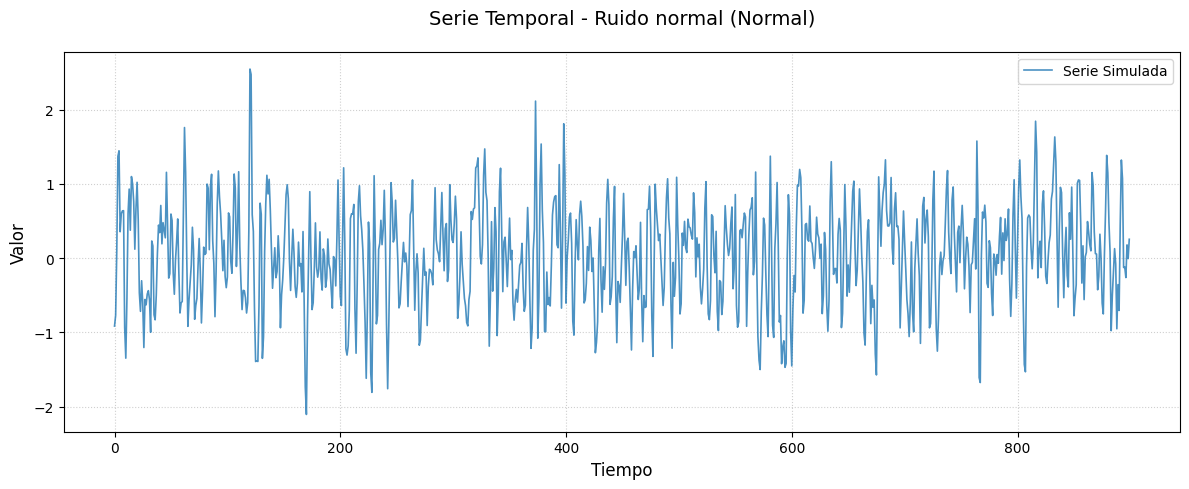

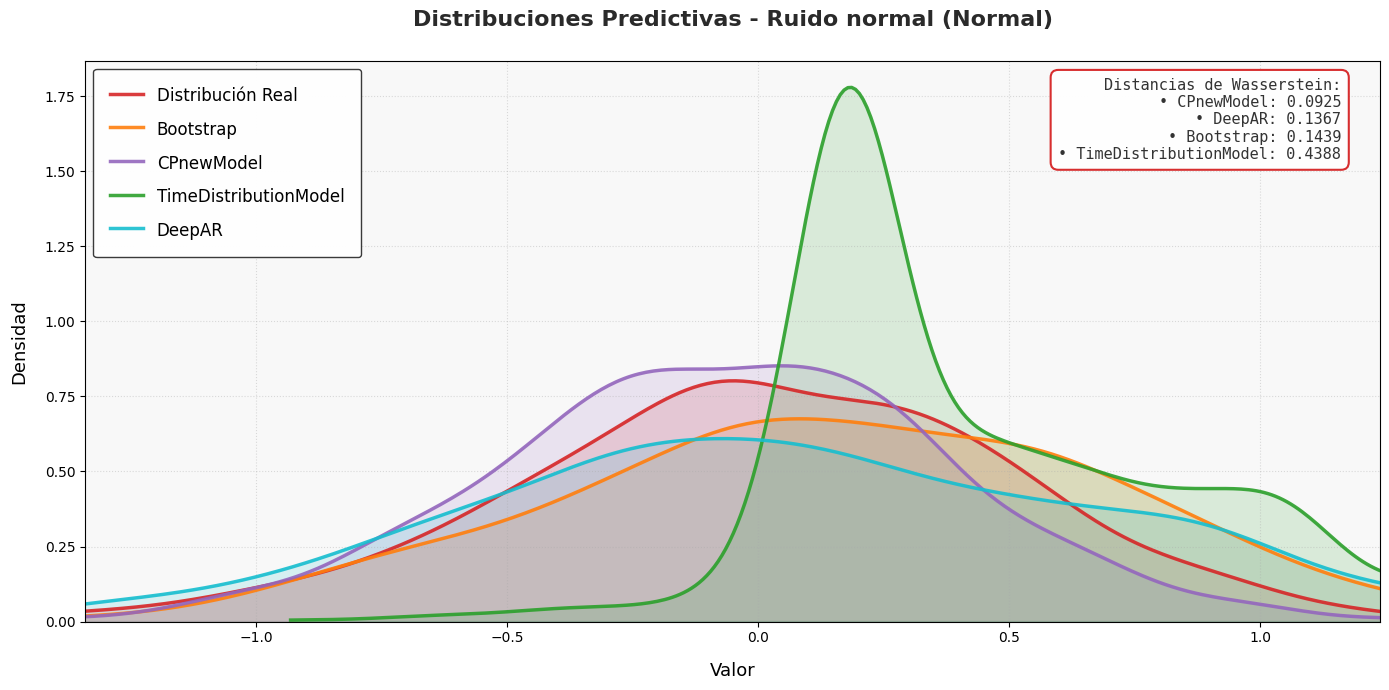


══════════════════════════════════════════════════
Hiperparámetros Óptimos:


n_lags       rho  poly_degree  hidden_size  num_layers  \
Modelo                                                                          
Bootstrap                   1       NaN          NaN          NaN         NaN   
CPnewModel                  8  0.972508          3.0          NaN         NaN   
TimeDistributionModel       4  0.826667          NaN          NaN         NaN   
DeepAR                      6       NaN          NaN         28.0         1.0   

                       dropout        lr  
Modelo                                    
Bootstrap                  NaN       NaN  
CPnewModel                 NaN       NaN  
TimeDistributionModel      NaN       NaN  
DeepAR                 0.18727  0.073467


══════════════════════════════════════════════════
Métricas de Desempeño:



##################################################
Ejecutando: Ruido uniform
##################################################

============================== Bootstrap ==============================
✅ Mejor n_lags encontrado: 1 (Wasserstein = 0.1891)

============================== CPnewModel ==============================
✅ Optimización exitosa:
  • Lags: 6
  • Rho: 0.704
  • Grado polinomial: 2
  • Distancia de Wasserstein: 0.7426

============================== TimeDistributionModel ==============================
Mejora encontrada: (1, np.float64(0.5)) - 0.1920
Mejora encontrada: (1, np.float64(0.5544444444444444)) - 0.1611
Mejora encontrada: (1, np.float64(0.7722222222222221)) - 0.1566
Mejora encontrada: (1, np.float64(0.8266666666666667)) - 0.1521
Mejora encontrada: (2, np.float64(0.5)) - 0.1238
Mejora encontrada: (2, np.float64(0.6088888888888889)) - 0.0962
✅ Optimización final: n_lags=2, rho=0.609
Distancia de Wasserstein: 0.0962

============================== DeepAR =======

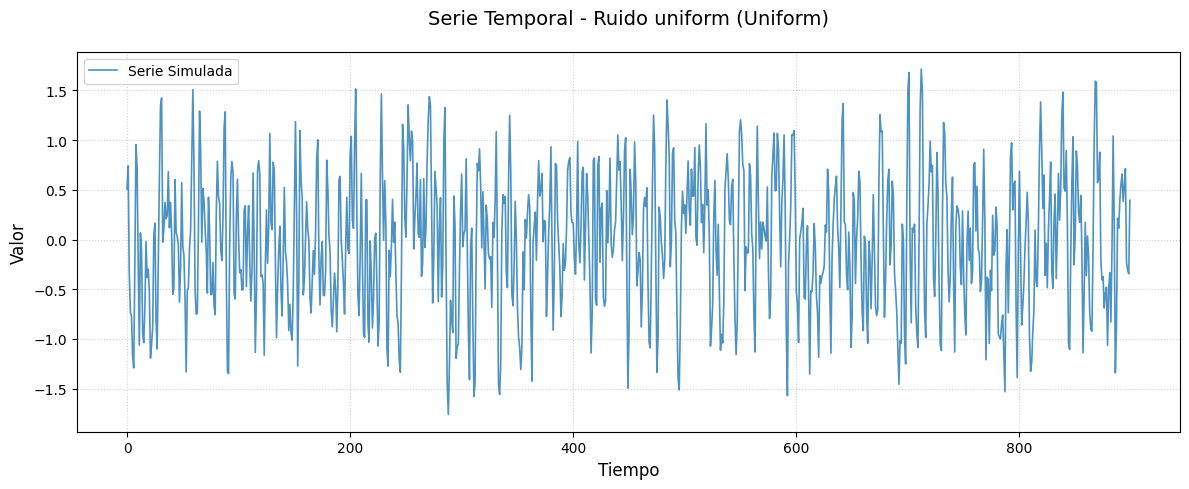

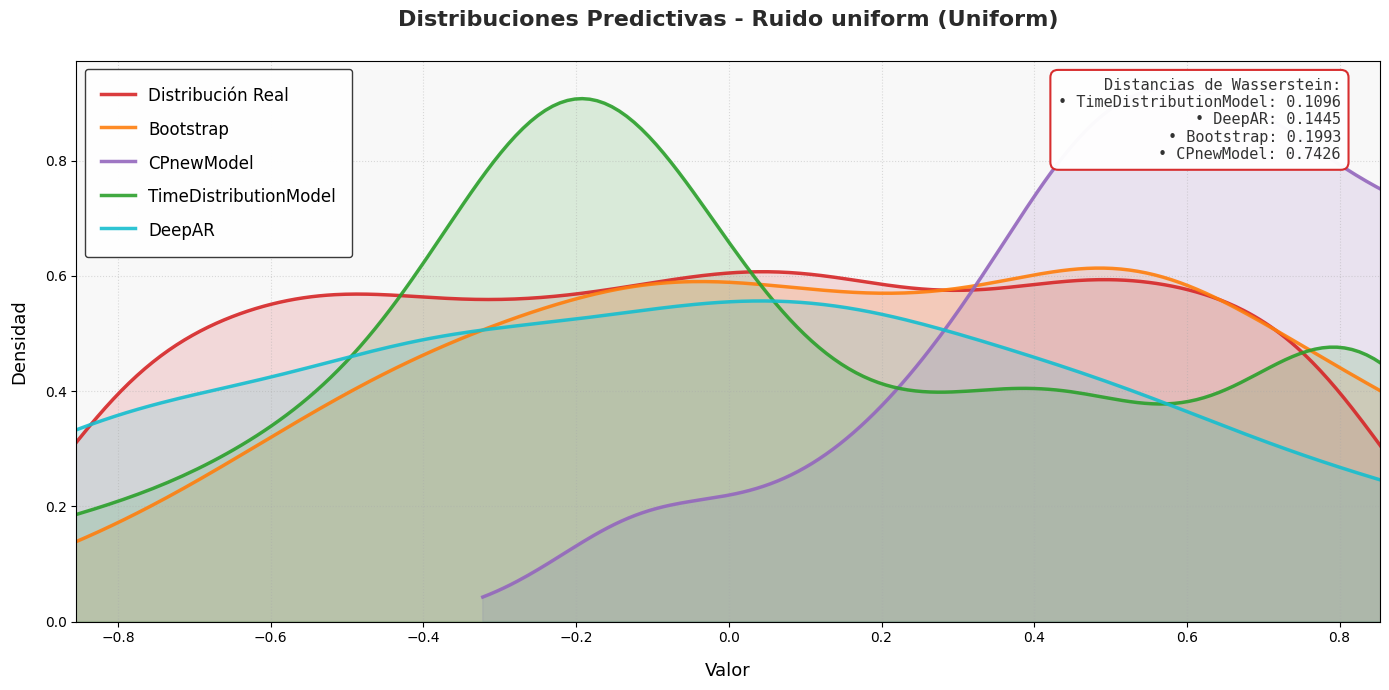


══════════════════════════════════════════════════
Hiperparámetros Óptimos:


n_lags       rho  poly_degree  hidden_size  num_layers  \
Modelo                                                                          
Bootstrap                   1       NaN          NaN          NaN         NaN   
CPnewModel                  6  0.704460          2.0          NaN         NaN   
TimeDistributionModel       2  0.608889          NaN          NaN         NaN   
DeepAR                      1       NaN          NaN         25.0         2.0   

                        dropout        lr  
Modelo                                     
Bootstrap                   NaN       NaN  
CPnewModel                  NaN       NaN  
TimeDistributionModel       NaN       NaN  
DeepAR                 0.371967  0.037928


══════════════════════════════════════════════════
Métricas de Desempeño:



##################################################
Ejecutando: Ruido t
##################################################

============================== Bootstrap ==============================
✅ Mejor n_lags encontrado: 4 (Wasserstein = 0.0485)

============================== CPnewModel ==============================
✅ Optimización exitosa:
  • Lags: 1
  • Rho: 0.700
  • Grado polinomial: 2
  • Distancia de Wasserstein: 0.8213

============================== TimeDistributionModel ==============================
Mejora encontrada: (1, np.float64(0.5)) - 0.4245
Mejora encontrada: (1, np.float64(0.5544444444444444)) - 0.4180
Mejora encontrada: (1, np.float64(0.6088888888888889)) - 0.3541
Mejora encontrada: (2, np.float64(0.7177777777777777)) - 0.3525
Mejora encontrada: (2, np.float64(0.99)) - 0.3462
Mejora encontrada: (6, np.float64(0.5)) - 0.2630
Mejora encontrada: (6, np.float64(0.5544444444444444)) - 0.2280
Mejora encontrada: (6, np.float64(0.6633333333333333)) - 0.2118
✅ Optimizació

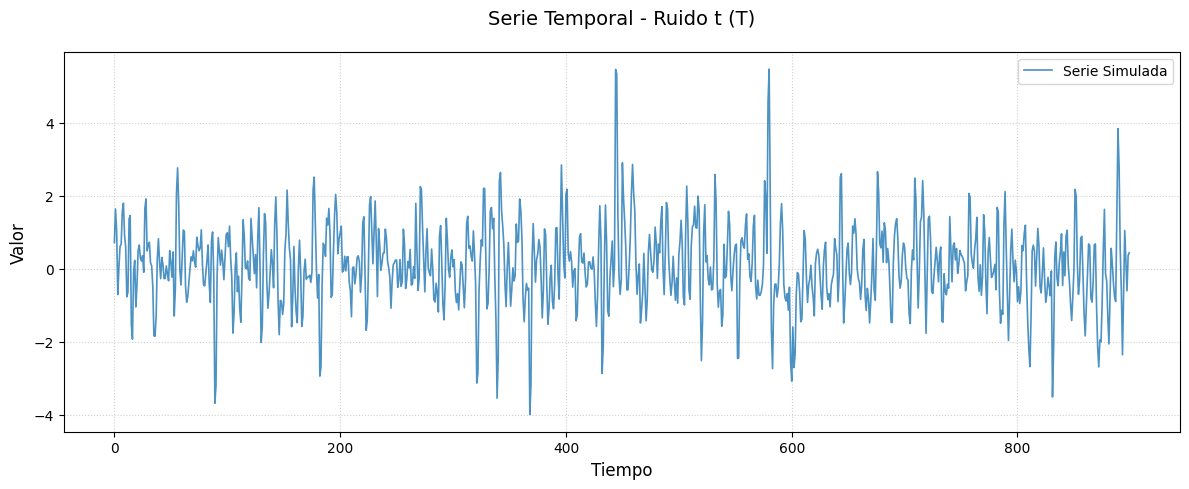

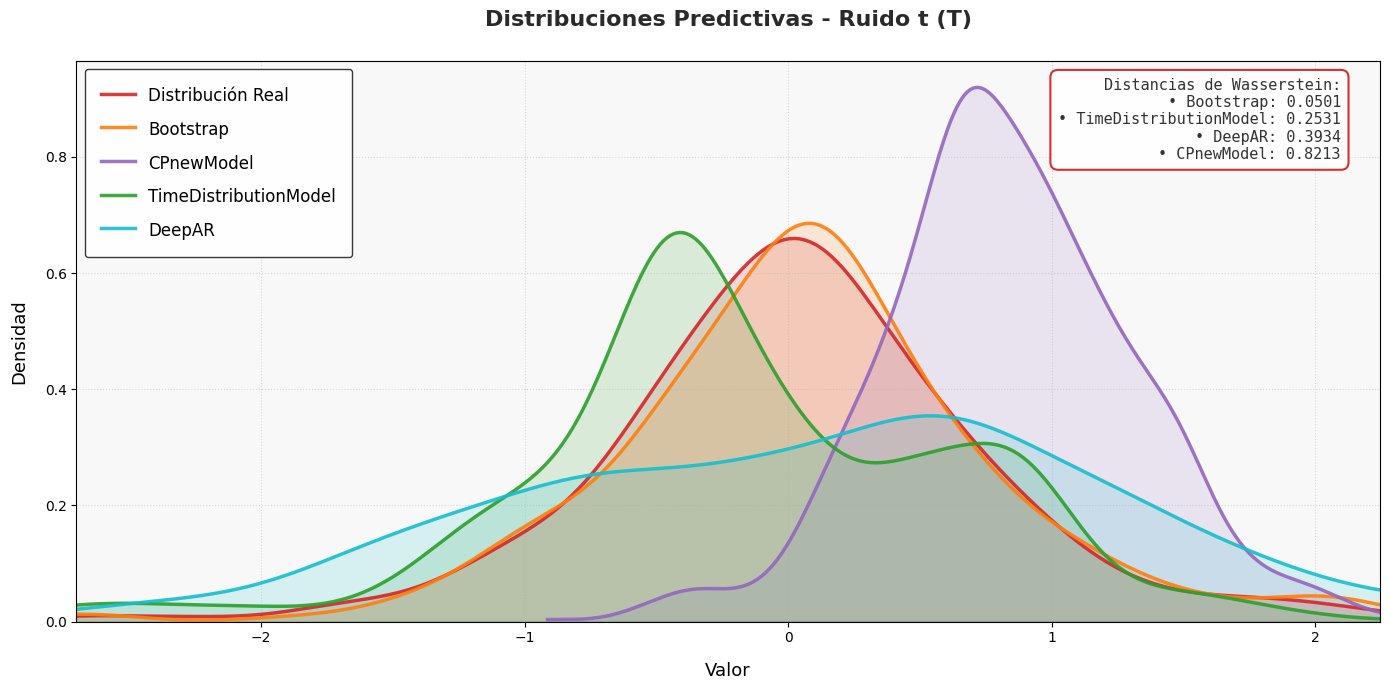


══════════════════════════════════════════════════
Hiperparámetros Óptimos:


n_lags       rho  poly_degree  hidden_size  num_layers  \
Modelo                                                                          
Bootstrap                   4       NaN          NaN          NaN         NaN   
CPnewModel                  1  0.700013          2.0          NaN         NaN   
TimeDistributionModel       6  0.663333          NaN          NaN         NaN   
DeepAR                      3       NaN          NaN         25.0         1.0   

                        dropout      lr  
Modelo                                   
Bootstrap                   NaN     NaN  
CPnewModel                  NaN     NaN  
TimeDistributionModel       NaN     NaN  
DeepAR                 0.037732  0.0472


══════════════════════════════════════════════════
Métricas de Desempeño:



##################################################
Ejecutando: Ruido exponential
##################################################

============================== Bootstrap ==============================
✅ Mejor n_lags encontrado: 1 (Wasserstein = 0.1338)

============================== CPnewModel ==============================
✅ Optimización exitosa:
  • Lags: 8
  • Rho: 0.700
  • Grado polinomial: 2
  • Distancia de Wasserstein: 0.3082

============================== TimeDistributionModel ==============================
Mejora encontrada: (1, np.float64(0.5)) - 0.1403
Mejora encontrada: (2, np.float64(0.5)) - 0.1296
Mejora encontrada: (2, np.float64(0.5544444444444444)) - 0.1194
Mejora encontrada: (2, np.float64(0.7722222222222221)) - 0.1177
Mejora encontrada: (6, np.float64(0.5544444444444444)) - 0.1133
✅ Optimización final: n_lags=6, rho=0.554
Distancia de Wasserstein: 0.1133

============================== DeepAR ==============================
✅ Optimización DeepAR Exitosa:
  • L

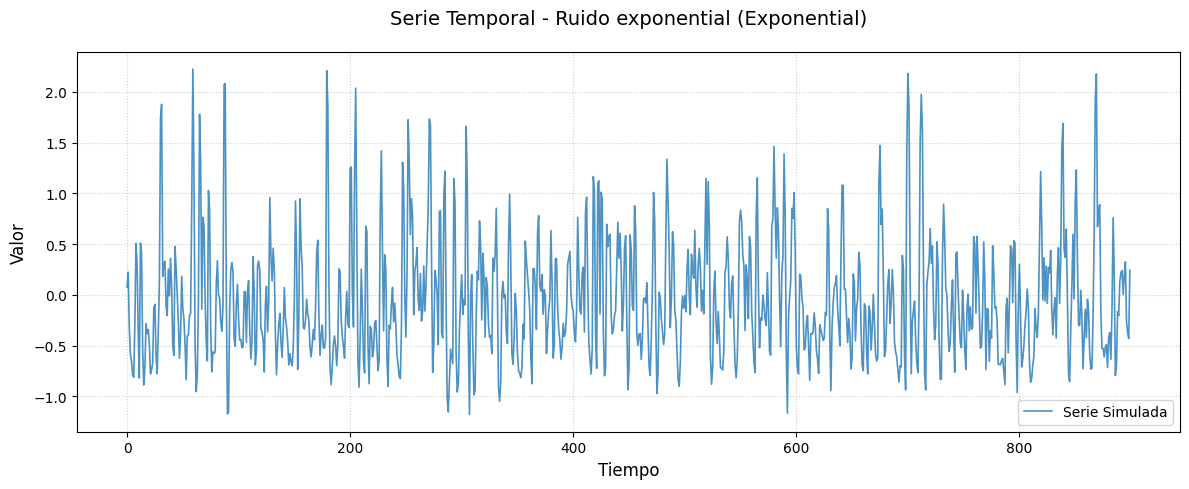

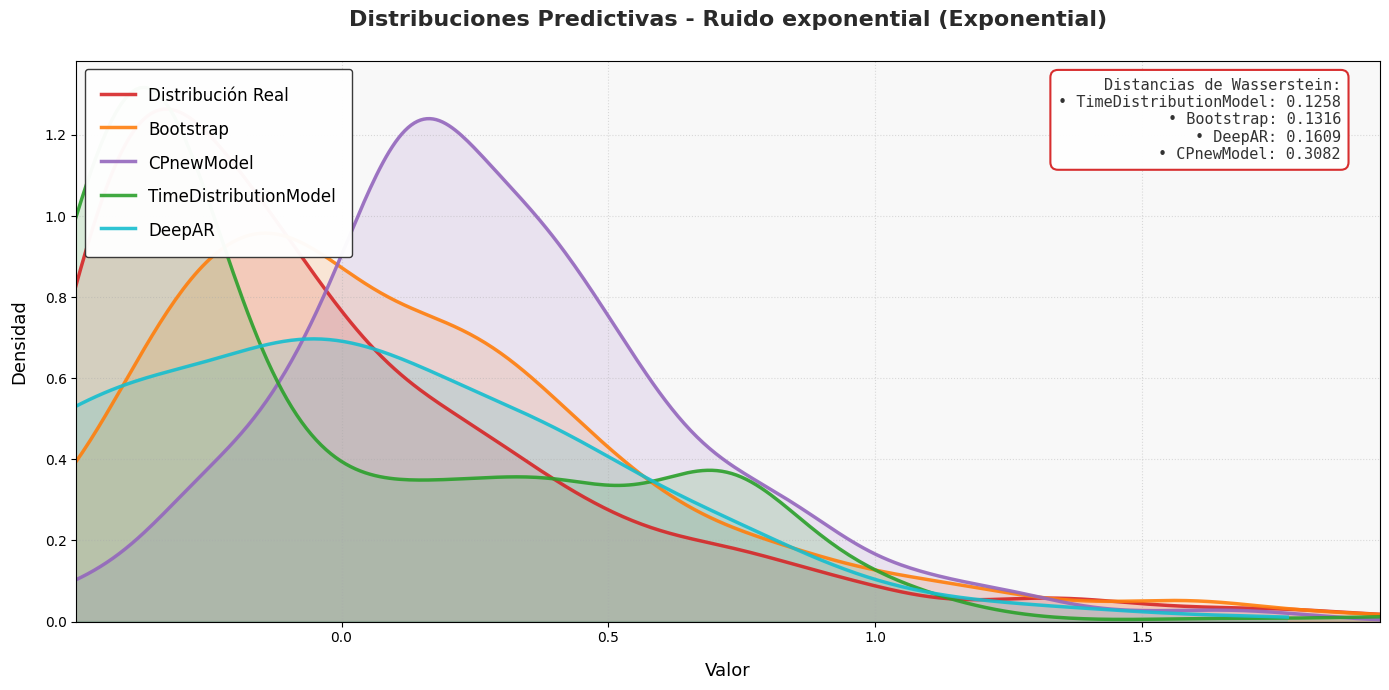


══════════════════════════════════════════════════
Hiperparámetros Óptimos:


n_lags       rho  poly_degree  hidden_size  num_layers  \
Modelo                                                                          
Bootstrap                   1       NaN          NaN          NaN         NaN   
CPnewModel                  8  0.700185          2.0          NaN         NaN   
TimeDistributionModel       6  0.554444          NaN          NaN         NaN   
DeepAR                      1       NaN          NaN          6.0         1.0   

                        dropout        lr  
Modelo                                     
Bootstrap                   NaN       NaN  
CPnewModel                  NaN       NaN  
TimeDistributionModel       NaN       NaN  
DeepAR                 0.292002  0.004545


══════════════════════════════════════════════════
Métricas de Desempeño:



##################################################
Ejecutando: Cambio gradual AR
##################################################
Error en Cambio gradual AR: 'n'

##################################################
Ejecutando: Cambio brusco MA
##################################################
Error en Cambio brusco MA: 'n'

##################################################
Ejecutando: Cambio mixto ARMA
##################################################
Error en Cambio mixto ARMA: 'n'

##################################################
Ejecutando: Estacionalidad diaria
##################################################

============================== Bootstrap ==============================
✅ Mejor n_lags encontrado: 1 (Wasserstein = 0.2560)

============================== CPnewModel ==============================
✅ Optimización exitosa:
  • Lags: 8
  • Rho: 0.973
  • Grado polinomial: 3
  • Distancia de Wasserstein: 0.2867

============================== TimeDistributionModel =====

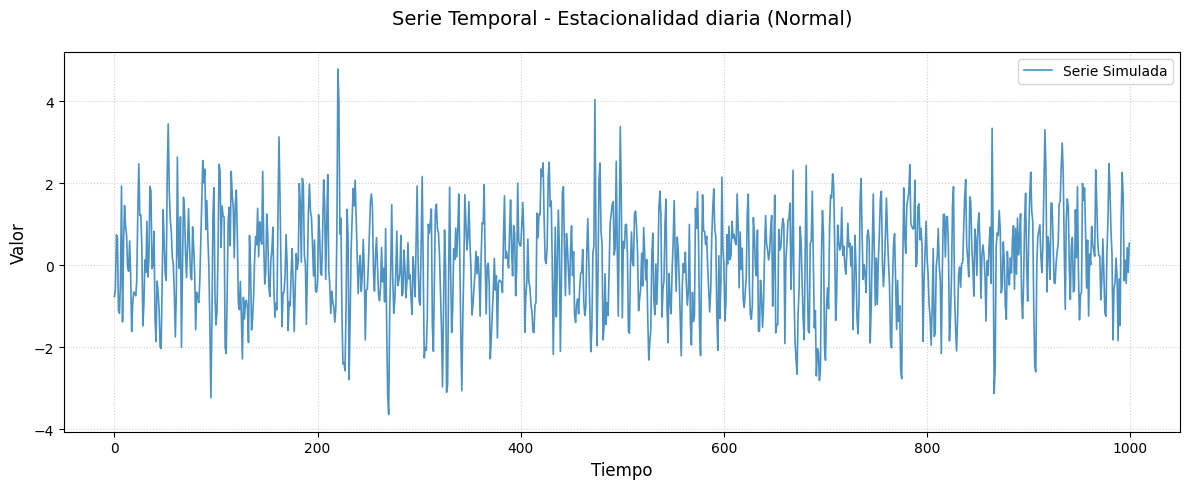

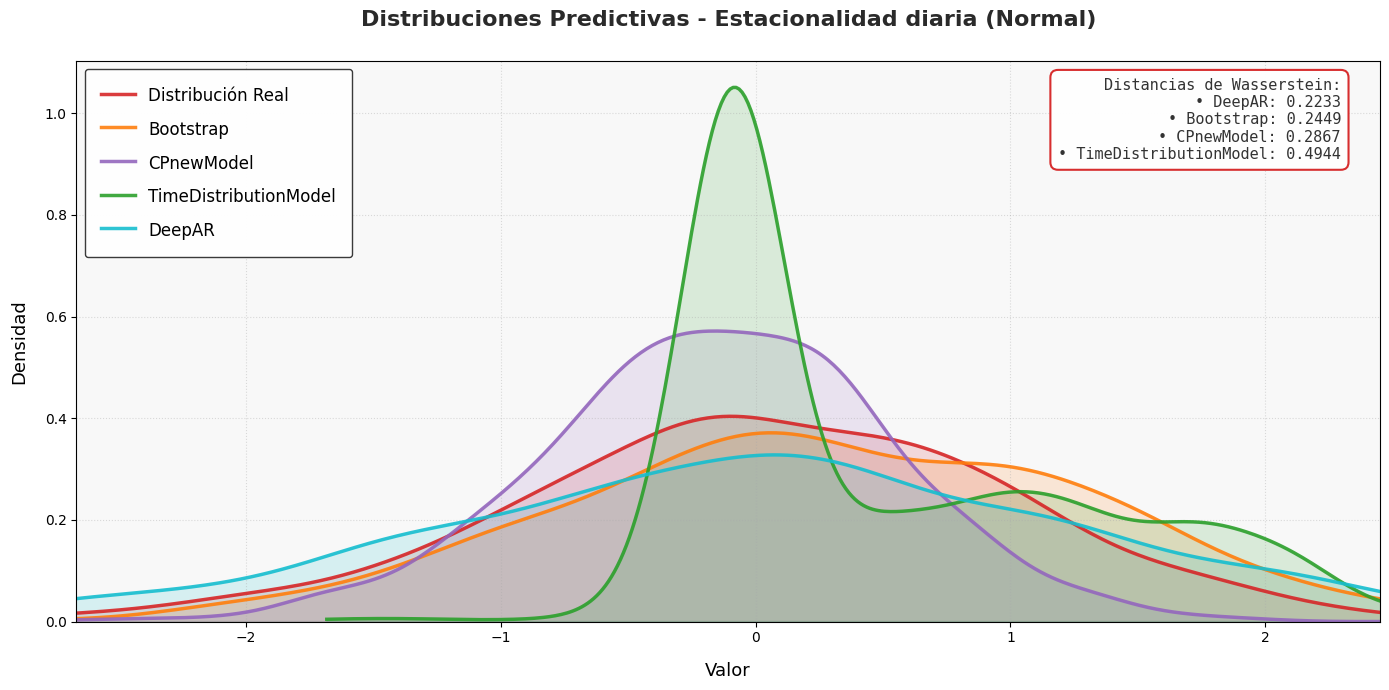


══════════════════════════════════════════════════
Hiperparámetros Óptimos:


n_lags       rho  poly_degree  hidden_size  num_layers  \
Modelo                                                                          
Bootstrap                   1       NaN          NaN          NaN         NaN   
CPnewModel                  8  0.972508          3.0          NaN         NaN   
TimeDistributionModel       9  0.772222          NaN          NaN         NaN   
DeepAR                      3       NaN          NaN         25.0         1.0   

                        dropout      lr  
Modelo                                   
Bootstrap                   NaN     NaN  
CPnewModel                  NaN     NaN  
TimeDistributionModel       NaN     NaN  
DeepAR                 0.037732  0.0472


══════════════════════════════════════════════════
Métricas de Desempeño:



##################################################
Ejecutando: Estacionalidad anual
##################################################

============================== Bootstrap ==============================
✅ Mejor n_lags encontrado: 1 (Wasserstein = 0.2560)

============================== CPnewModel ==============================
✅ Optimización exitosa:
  • Lags: 8
  • Rho: 0.973
  • Grado polinomial: 3
  • Distancia de Wasserstein: 0.2867

============================== TimeDistributionModel ==============================
Mejora encontrada: (1, np.float64(0.5)) - 1.0432
Mejora encontrada: (1, np.float64(0.5544444444444444)) - 1.0281
Mejora encontrada: (1, np.float64(0.7177777777777777)) - 1.0187
Mejora encontrada: (1, np.float64(0.7722222222222221)) - 0.9788
Mejora encontrada: (1, np.float64(0.9355555555555555)) - 0.9687
Mejora encontrada: (3, np.float64(0.5)) - 0.9273
Mejora encontrada: (3, np.float64(0.5544444444444444)) - 0.8944
Mejora encontrada: (3, np.float64(0.82666666666666

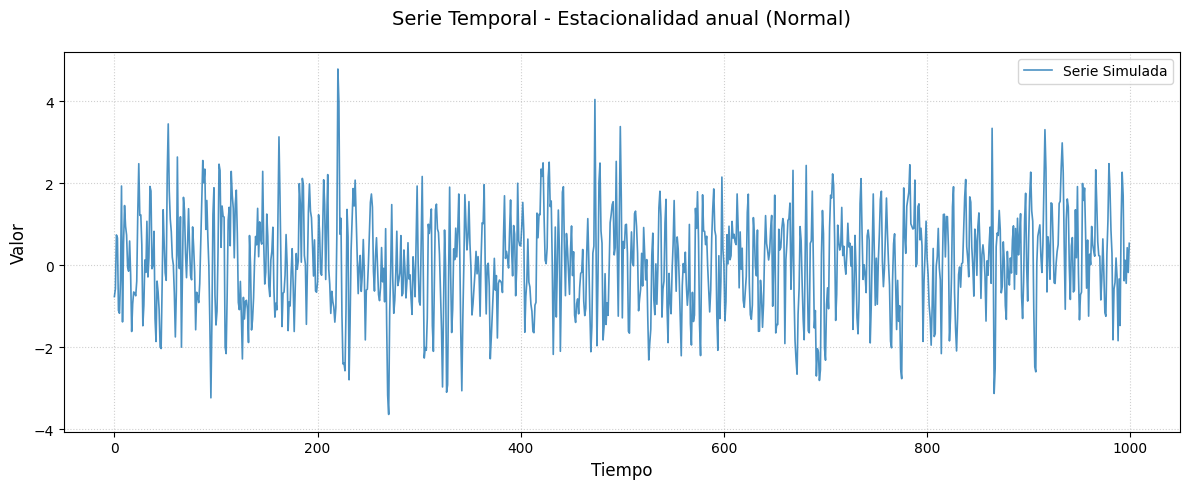

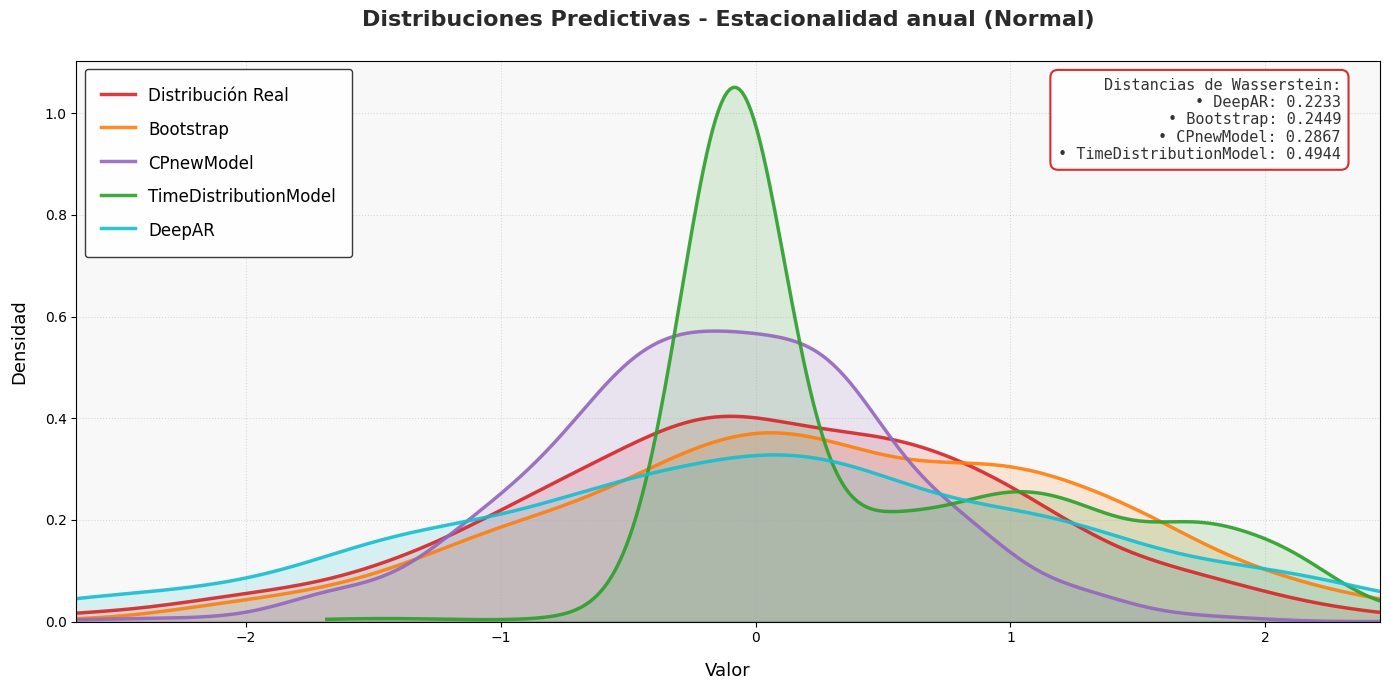


══════════════════════════════════════════════════
Hiperparámetros Óptimos:


n_lags       rho  poly_degree  hidden_size  num_layers  \
Modelo                                                                          
Bootstrap                   1       NaN          NaN          NaN         NaN   
CPnewModel                  8  0.972508          3.0          NaN         NaN   
TimeDistributionModel       9  0.772222          NaN          NaN         NaN   
DeepAR                      3       NaN          NaN         25.0         1.0   

                        dropout      lr  
Modelo                                   
Bootstrap                   NaN     NaN  
CPnewModel                  NaN     NaN  
TimeDistributionModel       NaN     NaN  
DeepAR                 0.037732  0.0472


══════════════════════════════════════════════════
Métricas de Desempeño:



##################################################
Ejecutando: Estacionalidad compleja
##################################################

============================== Bootstrap ==============================
✅ Mejor n_lags encontrado: 1 (Wasserstein = 0.2560)

============================== CPnewModel ==============================
✅ Optimización exitosa:
  • Lags: 8
  • Rho: 0.973
  • Grado polinomial: 3
  • Distancia de Wasserstein: 0.2867

============================== TimeDistributionModel ==============================
Mejora encontrada: (1, np.float64(0.5)) - 1.0432
Mejora encontrada: (1, np.float64(0.5544444444444444)) - 1.0281
Mejora encontrada: (1, np.float64(0.7177777777777777)) - 1.0187
Mejora encontrada: (1, np.float64(0.7722222222222221)) - 0.9788
Mejora encontrada: (1, np.float64(0.9355555555555555)) - 0.9687
Mejora encontrada: (3, np.float64(0.5)) - 0.9273
Mejora encontrada: (3, np.float64(0.5544444444444444)) - 0.8944
Mejora encontrada: (3, np.float64(0.82666666666

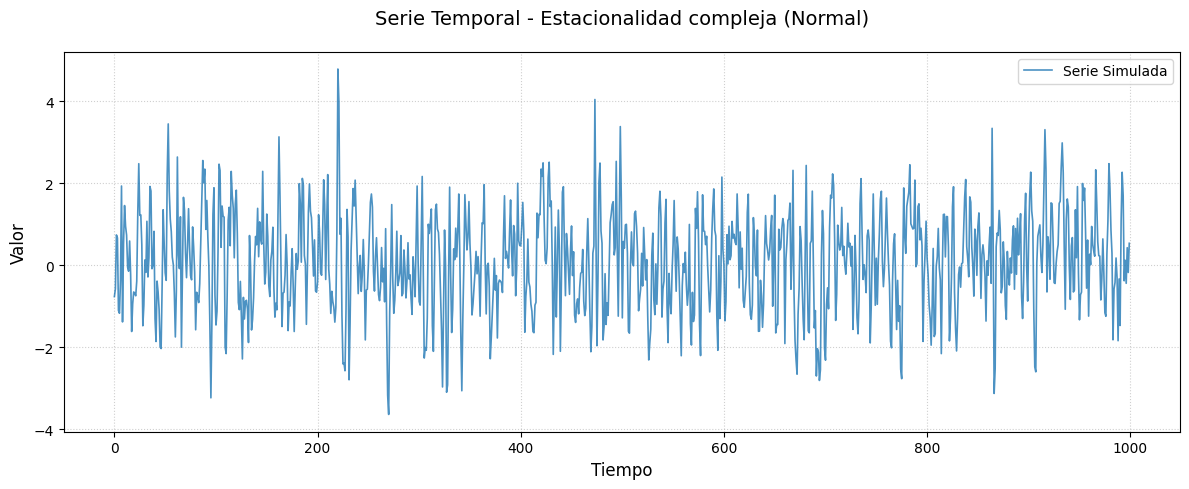

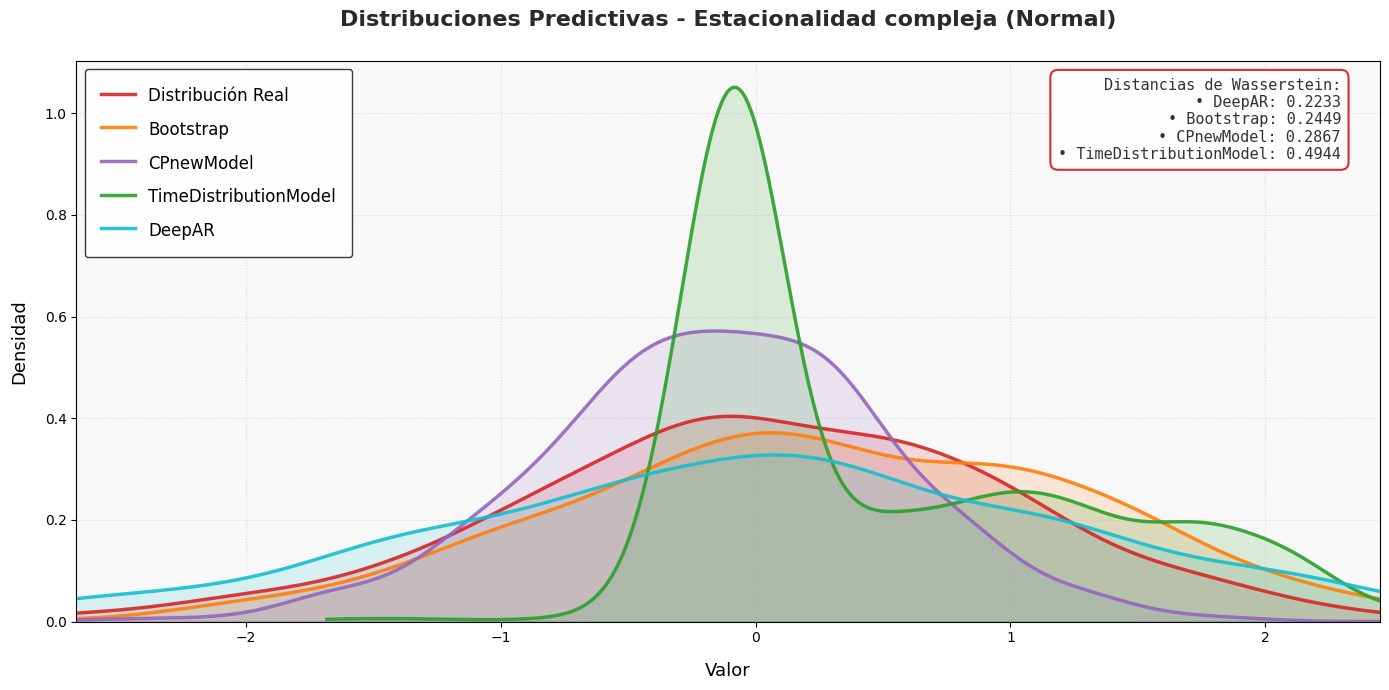


══════════════════════════════════════════════════
Hiperparámetros Óptimos:


n_lags       rho  poly_degree  hidden_size  num_layers  \
Modelo                                                                          
Bootstrap                   1       NaN          NaN          NaN         NaN   
CPnewModel                  8  0.972508          3.0          NaN         NaN   
TimeDistributionModel       9  0.772222          NaN          NaN         NaN   
DeepAR                      3       NaN          NaN         25.0         1.0   

                        dropout      lr  
Modelo                                   
Bootstrap                   NaN     NaN  
CPnewModel                  NaN     NaN  
TimeDistributionModel       NaN     NaN  
DeepAR                 0.037732  0.0472


══════════════════════════════════════════════════
Métricas de Desempeño:



##################################################
Ejecutando: Umbral no lineal (Z=0.5)
##################################################

============================== Bootstrap ==============================
✅ Mejor n_lags encontrado: 1 (Wasserstein = 0.2803)

============================== CPnewModel ==============================
✅ Optimización exitosa:
  • Lags: 8
  • Rho: 0.973
  • Grado polinomial: 3
  • Distancia de Wasserstein: 0.1549

============================== TimeDistributionModel ==============================
Mejora encontrada: (1, np.float64(0.5)) - 1.0949
Mejora encontrada: (1, np.float64(0.6633333333333333)) - 1.0851
Mejora encontrada: (1, np.float64(0.7177777777777777)) - 1.0839
Mejora encontrada: (1, np.float64(0.7722222222222221)) - 1.0713
Mejora encontrada: (1, np.float64(0.9355555555555555)) - 1.0670
Mejora encontrada: (1, np.float64(0.99)) - 1.0501
Mejora encontrada: (11, np.float64(0.5544444444444444)) - 1.0336
Mejora encontrada: (11, np.float64(0.99)) - 

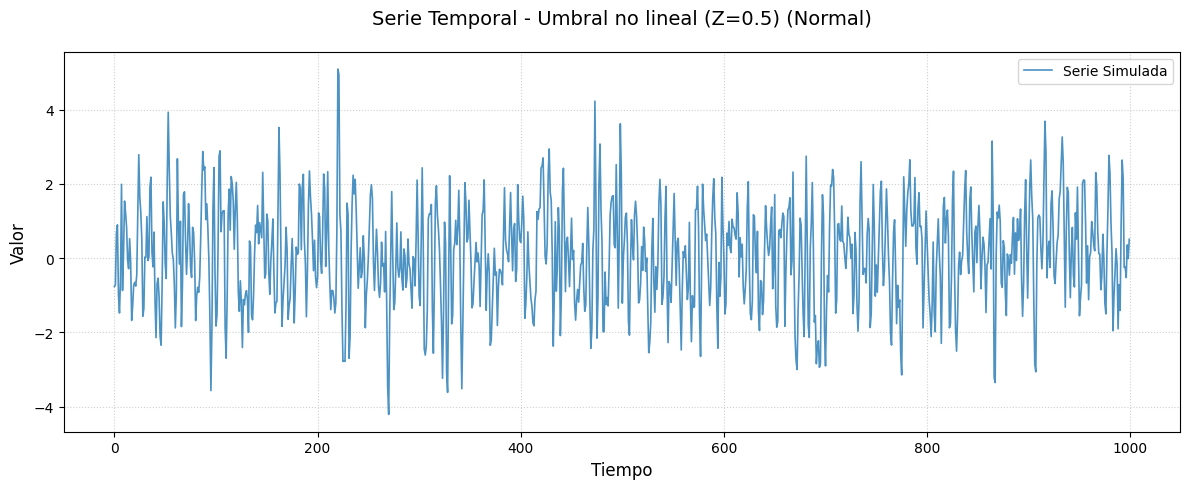

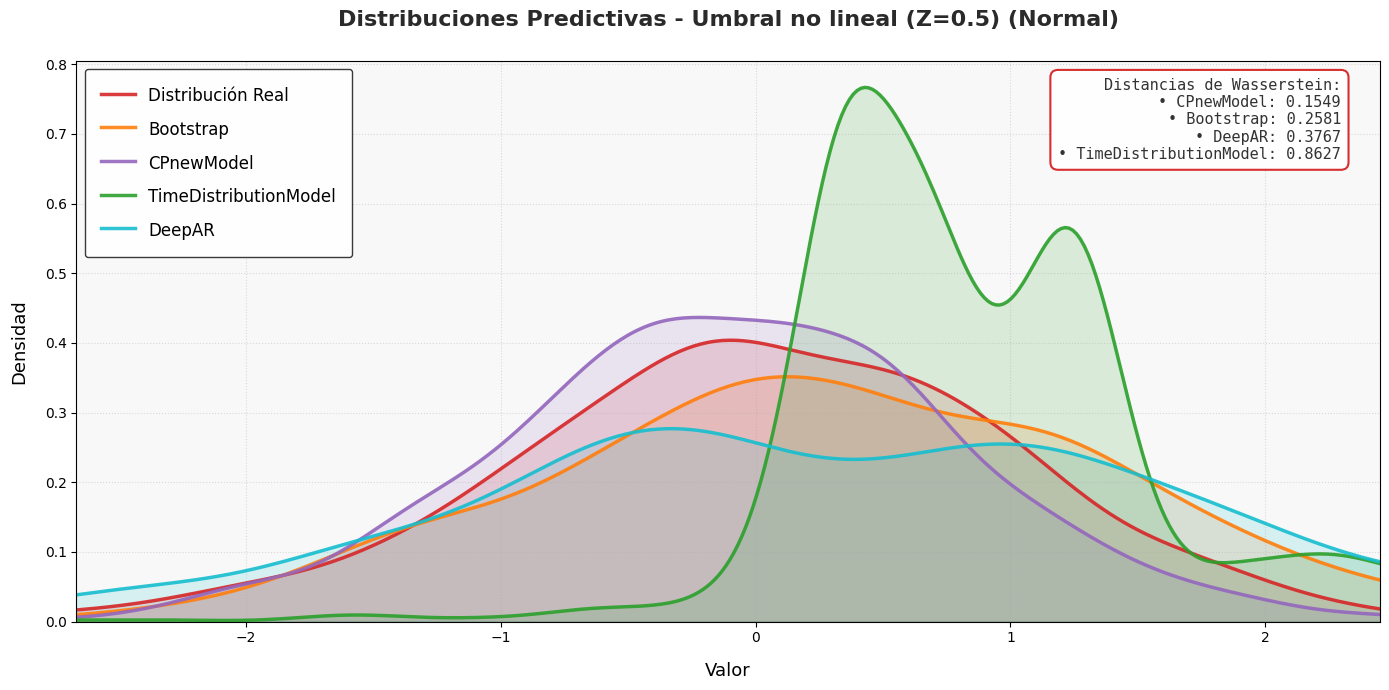


══════════════════════════════════════════════════
Hiperparámetros Óptimos:


n_lags       rho  poly_degree  hidden_size  num_layers  \
Modelo                                                                          
Bootstrap                   1       NaN          NaN          NaN         NaN   
CPnewModel                  8  0.972508          3.0          NaN         NaN   
TimeDistributionModel      12  0.500000          NaN          NaN         NaN   
DeepAR                      1       NaN          NaN          6.0         1.0   

                        dropout        lr  
Modelo                                     
Bootstrap                   NaN       NaN  
CPnewModel                  NaN       NaN  
TimeDistributionModel       NaN       NaN  
DeepAR                 0.292002  0.004545


══════════════════════════════════════════════════
Métricas de Desempeño:



##################################################
Ejecutando: Transformación logarítmica
##################################################

============================== Bootstrap ==============================
✅ Mejor n_lags encontrado: 1 (Wasserstein = 0.2803)

============================== CPnewModel ==============================
✅ Optimización exitosa:
  • Lags: 8
  • Rho: 0.973
  • Grado polinomial: 3
  • Distancia de Wasserstein: 0.1549

============================== TimeDistributionModel ==============================
Mejora encontrada: (1, np.float64(0.5)) - 1.0949
Mejora encontrada: (1, np.float64(0.6633333333333333)) - 1.0851
Mejora encontrada: (1, np.float64(0.7177777777777777)) - 1.0839
Mejora encontrada: (1, np.float64(0.7722222222222221)) - 1.0713
Mejora encontrada: (1, np.float64(0.9355555555555555)) - 1.0670
Mejora encontrada: (1, np.float64(0.99)) - 1.0501
Mejora encontrada: (11, np.float64(0.5544444444444444)) - 1.0336
Mejora encontrada: (11, np.float64(0.99)) 

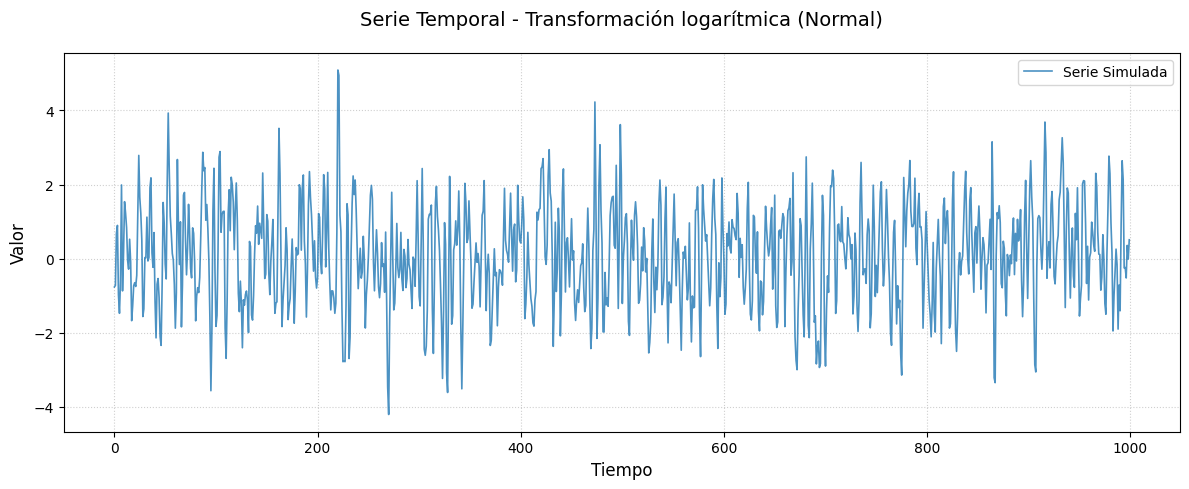

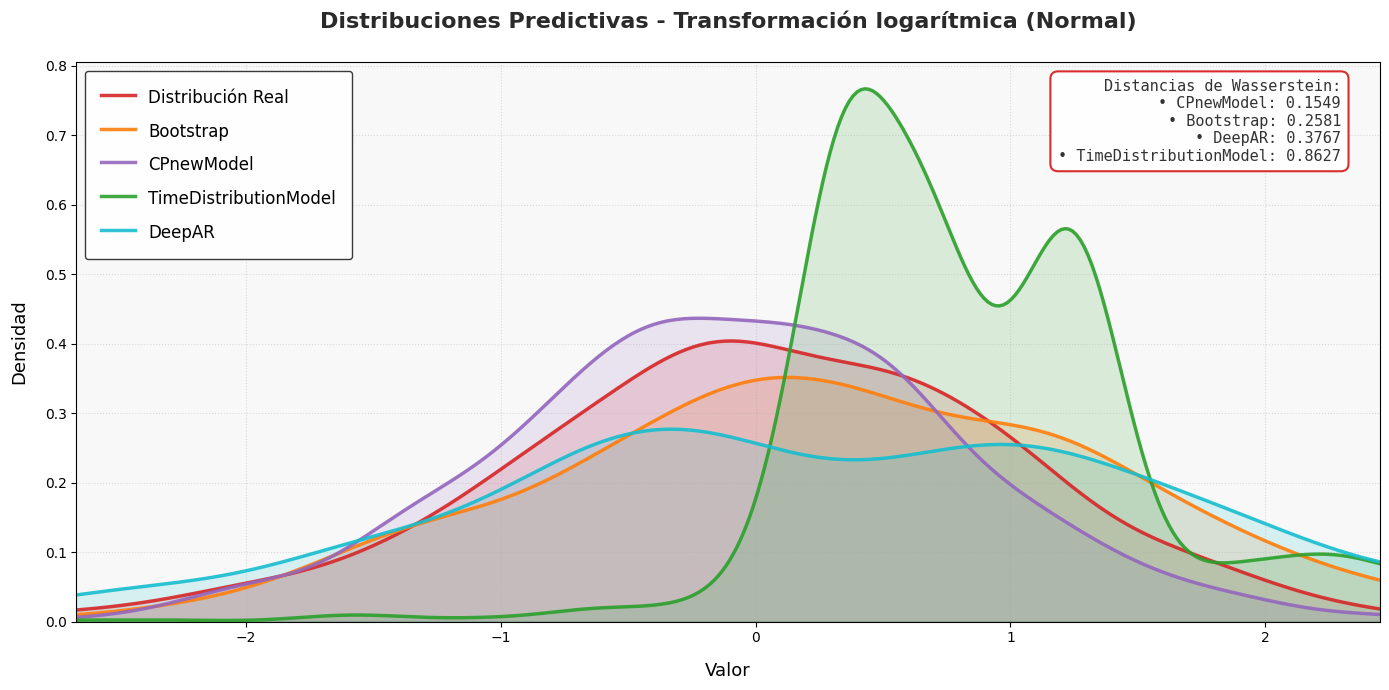


══════════════════════════════════════════════════
Hiperparámetros Óptimos:


n_lags       rho  poly_degree  hidden_size  num_layers  \
Modelo                                                                          
Bootstrap                   1       NaN          NaN          NaN         NaN   
CPnewModel                  8  0.972508          3.0          NaN         NaN   
TimeDistributionModel      12  0.500000          NaN          NaN         NaN   
DeepAR                      1       NaN          NaN          6.0         1.0   

                        dropout        lr  
Modelo                                     
Bootstrap                   NaN       NaN  
CPnewModel                  NaN       NaN  
TimeDistributionModel       NaN       NaN  
DeepAR                 0.292002  0.004545


══════════════════════════════════════════════════
Métricas de Desempeño:



##################################################
Ejecutando: Componente cúbico
##################################################

============================== Bootstrap ==============================
✅ Mejor n_lags encontrado: 1 (Wasserstein = 0.2803)

============================== CPnewModel ==============================
✅ Optimización exitosa:
  • Lags: 8
  • Rho: 0.973
  • Grado polinomial: 3
  • Distancia de Wasserstein: 0.1549

============================== TimeDistributionModel ==============================
Mejora encontrada: (1, np.float64(0.5)) - 1.0949
Mejora encontrada: (1, np.float64(0.6633333333333333)) - 1.0851
Mejora encontrada: (1, np.float64(0.7177777777777777)) - 1.0839
Mejora encontrada: (1, np.float64(0.7722222222222221)) - 1.0713
Mejora encontrada: (1, np.float64(0.9355555555555555)) - 1.0670
Mejora encontrada: (1, np.float64(0.99)) - 1.0501
Mejora encontrada: (11, np.float64(0.5544444444444444)) - 1.0336
Mejora encontrada: (11, np.float64(0.99)) - 1.0310


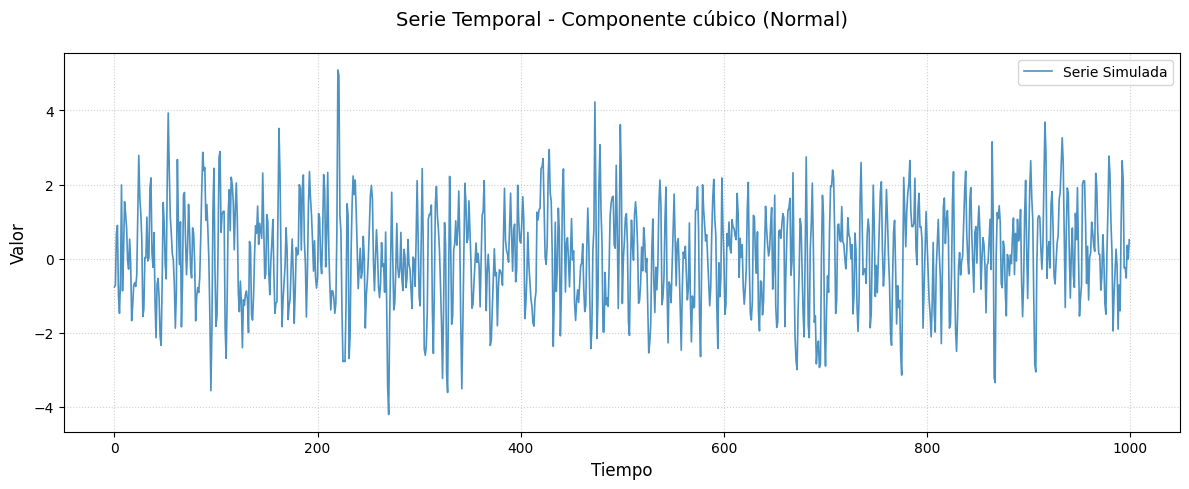

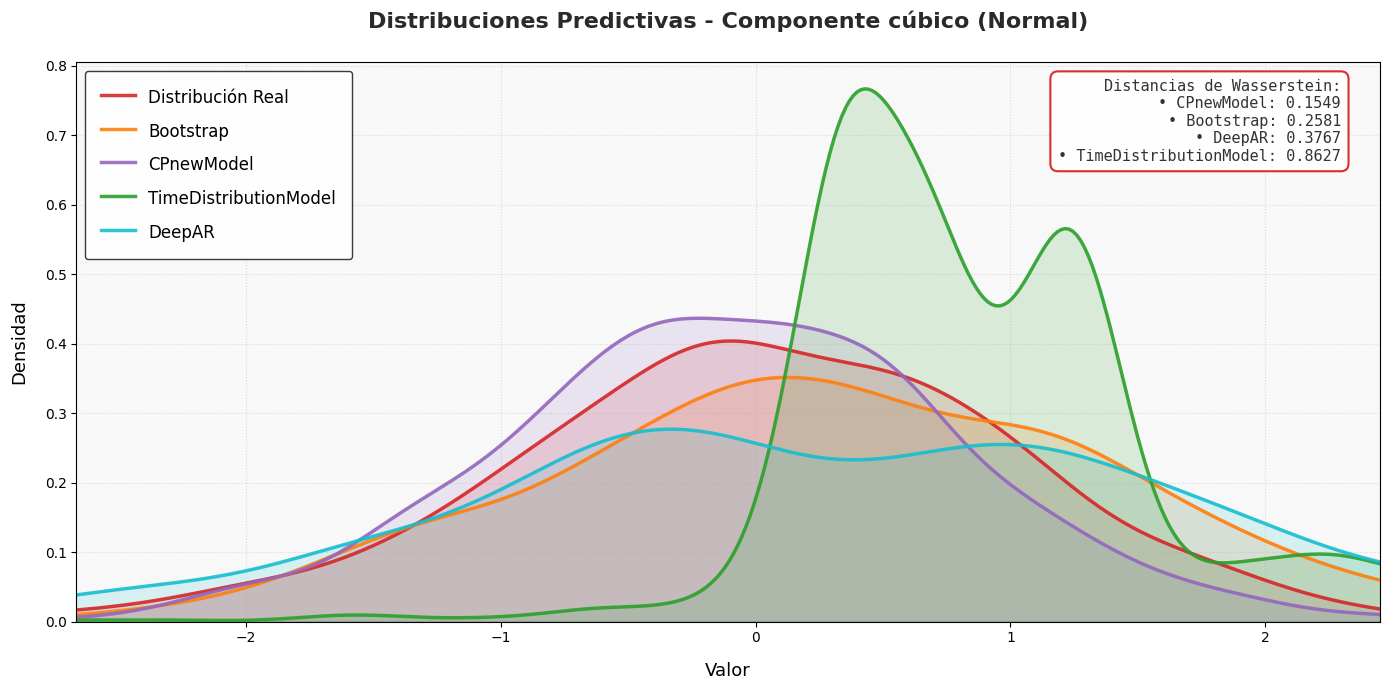


══════════════════════════════════════════════════
Hiperparámetros Óptimos:


n_lags       rho  poly_degree  hidden_size  num_layers  \
Modelo                                                                          
Bootstrap                   1       NaN          NaN          NaN         NaN   
CPnewModel                  8  0.972508          3.0          NaN         NaN   
TimeDistributionModel      12  0.500000          NaN          NaN         NaN   
DeepAR                      1       NaN          NaN          6.0         1.0   

                        dropout        lr  
Modelo                                     
Bootstrap                   NaN       NaN  
CPnewModel                  NaN       NaN  
TimeDistributionModel       NaN       NaN  
DeepAR                 0.292002  0.004545


══════════════════════════════════════════════════
Métricas de Desempeño:



##################################################
Ejecutando: Volatilidad moderada (GARCH)
##################################################

============================== Bootstrap ==============================
✅ Mejor n_lags encontrado: 1 (Wasserstein = 0.3771)

============================== CPnewModel ==============================
✅ Optimización exitosa:
  • Lags: 7
  • Rho: 0.975
  • Grado polinomial: 3
  • Distancia de Wasserstein: 0.4213

============================== TimeDistributionModel ==============================
Mejora encontrada: (1, np.float64(0.5)) - 0.3121
Mejora encontrada: (1, np.float64(0.5544444444444444)) - 0.2879
Mejora encontrada: (2, np.float64(0.5)) - 0.2450
Mejora encontrada: (2, np.float64(0.6088888888888889)) - 0.2392
Mejora encontrada: (2, np.float64(0.7722222222222221)) - 0.2375
Mejora encontrada: (2, np.float64(0.8811111111111111)) - 0.2355
Mejora encontrada: (2, np.float64(0.99)) - 0.2283
Mejora encontrada: (3, np.float64(0.5)) - 0.2186
Mejora 

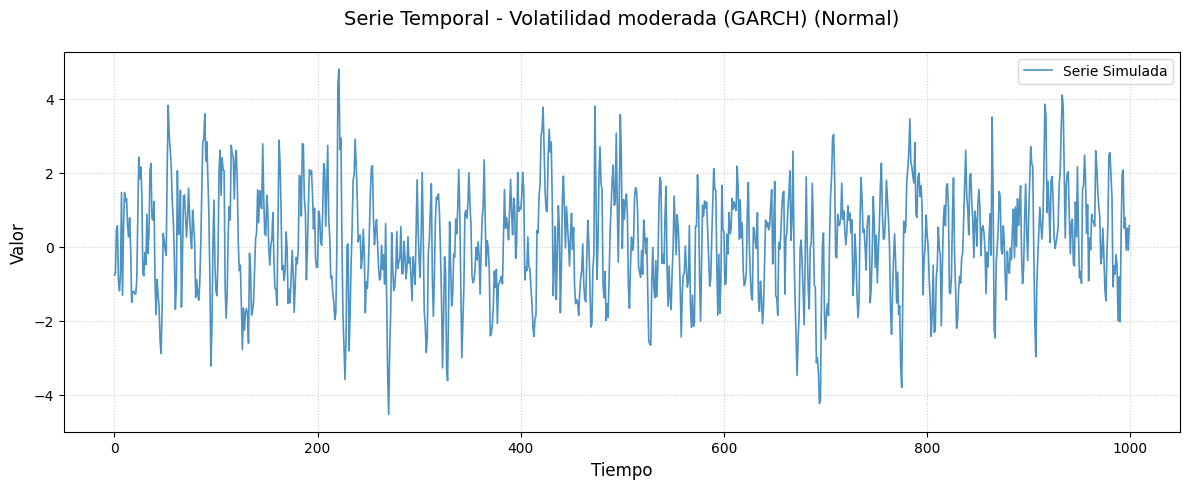

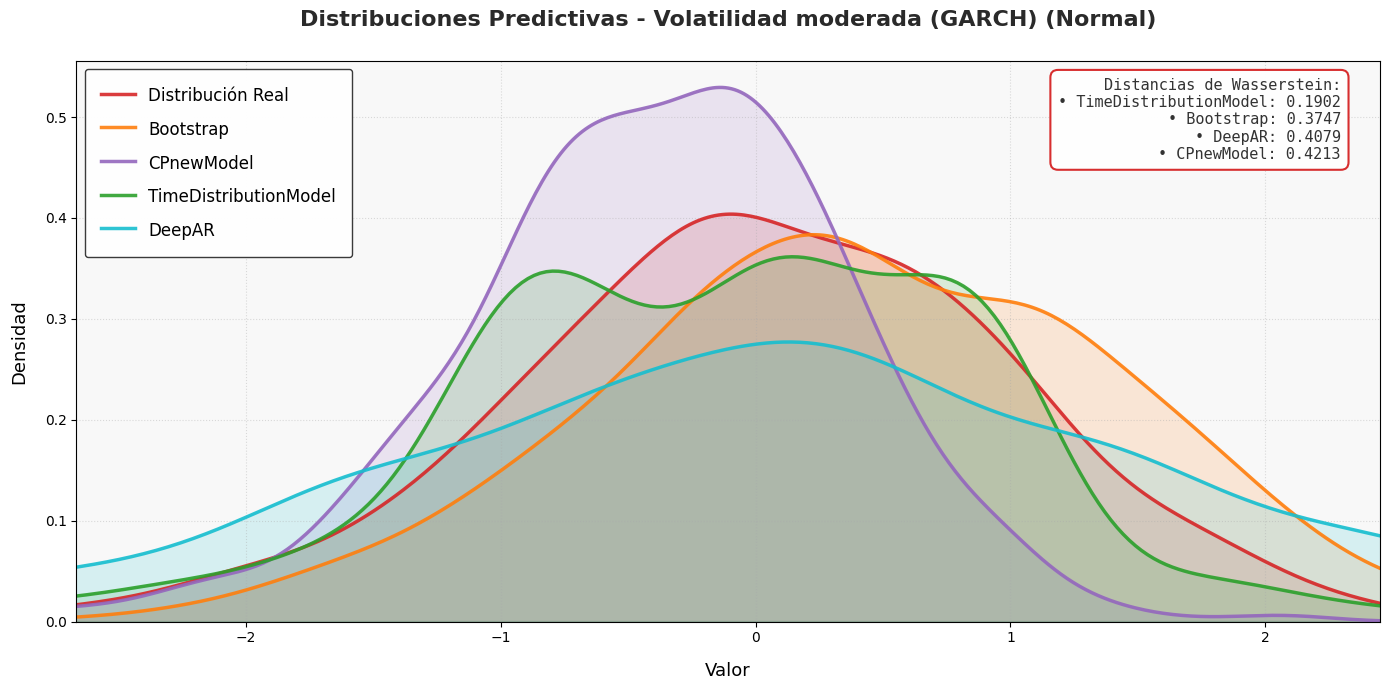


══════════════════════════════════════════════════
Hiperparámetros Óptimos:


n_lags       rho  poly_degree  hidden_size  num_layers  \
Modelo                                                                          
Bootstrap                   1       NaN          NaN          NaN         NaN   
CPnewModel                  7  0.975217          3.0          NaN         NaN   
TimeDistributionModel       9  0.554444          NaN          NaN         NaN   
DeepAR                      3       NaN          NaN         25.0         1.0   

                        dropout      lr  
Modelo                                   
Bootstrap                   NaN     NaN  
CPnewModel                  NaN     NaN  
TimeDistributionModel       NaN     NaN  
DeepAR                 0.037732  0.0472


══════════════════════════════════════════════════
Métricas de Desempeño:



##################################################
Ejecutando: Volatilidad explosiva (GARCH)
##################################################

============================== Bootstrap ==============================
✅ Mejor n_lags encontrado: 1 (Wasserstein = 0.3771)

============================== CPnewModel ==============================
✅ Optimización exitosa:
  • Lags: 7
  • Rho: 0.975
  • Grado polinomial: 3
  • Distancia de Wasserstein: 0.4213

============================== TimeDistributionModel ==============================
Mejora encontrada: (1, np.float64(0.5)) - 0.3121
Mejora encontrada: (1, np.float64(0.5544444444444444)) - 0.2879
Mejora encontrada: (2, np.float64(0.5)) - 0.2450
Mejora encontrada: (2, np.float64(0.6088888888888889)) - 0.2392
Mejora encontrada: (2, np.float64(0.7722222222222221)) - 0.2375
Mejora encontrada: (2, np.float64(0.8811111111111111)) - 0.2355
Mejora encontrada: (2, np.float64(0.99)) - 0.2283
Mejora encontrada: (3, np.float64(0.5)) - 0.2186
Mejora

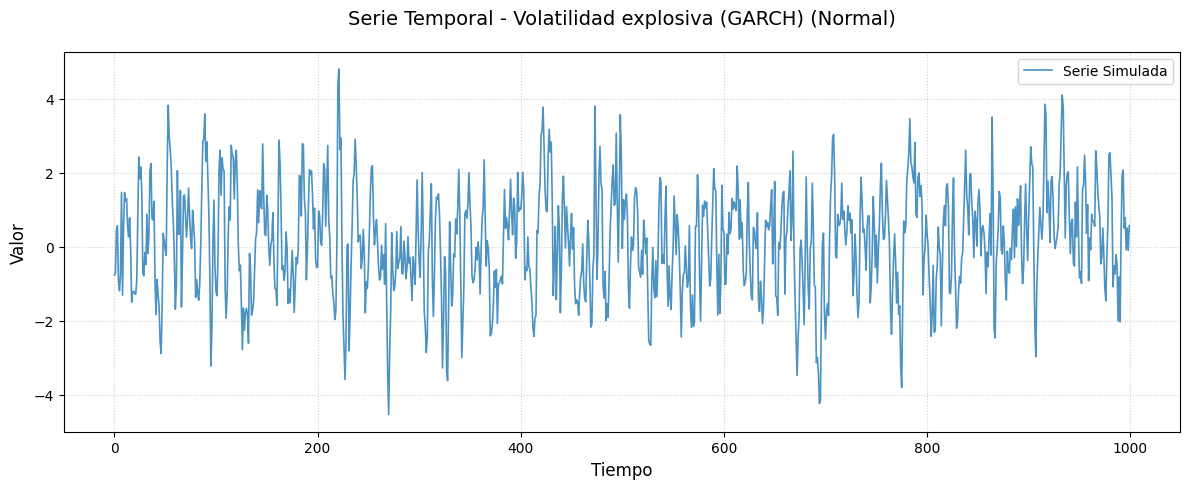

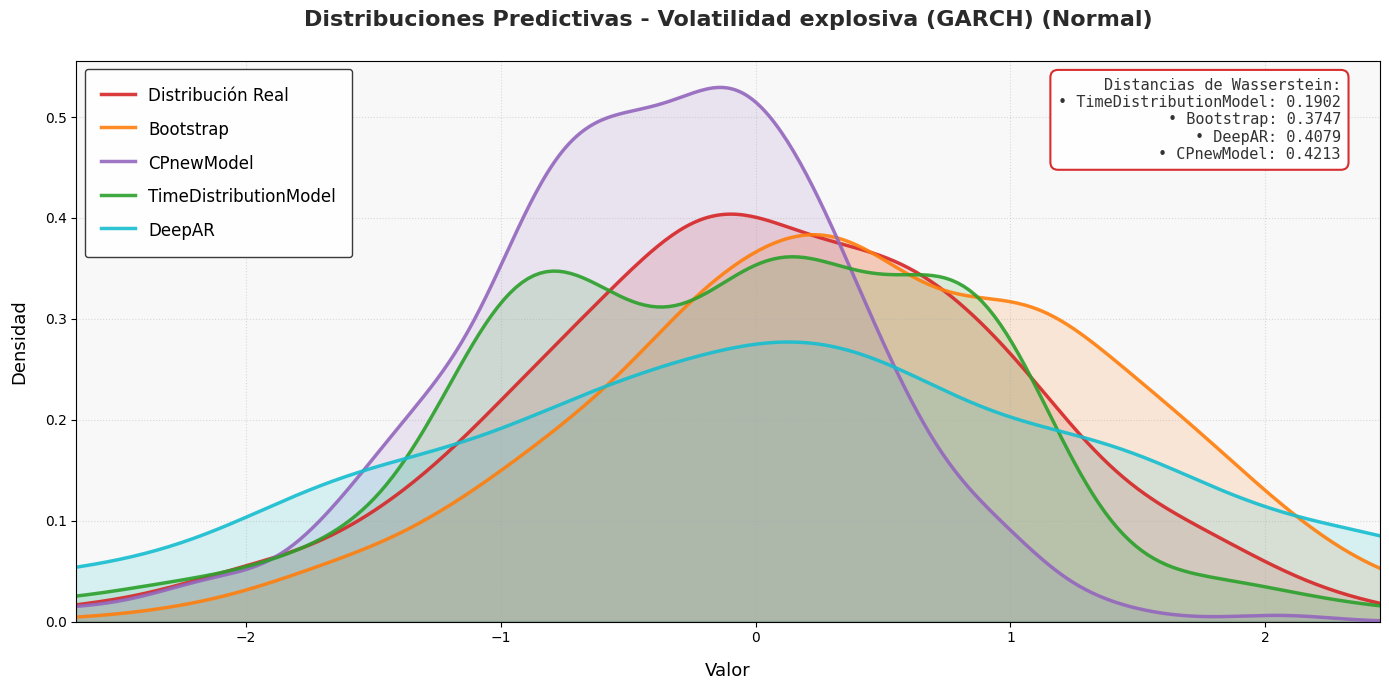


══════════════════════════════════════════════════
Hiperparámetros Óptimos:


n_lags       rho  poly_degree  hidden_size  num_layers  \
Modelo                                                                          
Bootstrap                   1       NaN          NaN          NaN         NaN   
CPnewModel                  7  0.975217          3.0          NaN         NaN   
TimeDistributionModel       9  0.554444          NaN          NaN         NaN   
DeepAR                      3       NaN          NaN         25.0         1.0   

                        dropout      lr  
Modelo                                   
Bootstrap                   NaN     NaN  
CPnewModel                  NaN     NaN  
TimeDistributionModel       NaN     NaN  
DeepAR                 0.037732  0.0472


══════════════════════════════════════════════════
Métricas de Desempeño:



##################################################
Ejecutando: Memoria larga (d=0.4)
##################################################

============================== Bootstrap ==============================
✅ Mejor n_lags encontrado: 3 (Wasserstein = 0.1155)

============================== CPnewModel ==============================
✅ Optimización exitosa:
  • Lags: 8
  • Rho: 0.949
  • Grado polinomial: 3
  • Distancia de Wasserstein: 0.5071

============================== TimeDistributionModel ==============================
Mejora encontrada: (1, np.float64(0.5)) - 0.6409
Mejora encontrada: (1, np.float64(0.5544444444444444)) - 0.6260
Mejora encontrada: (1, np.float64(0.6088888888888889)) - 0.5731
✅ Optimización final: n_lags=1, rho=0.609
Distancia de Wasserstein: 0.5731

============================== DeepAR ==============================
✅ Optimización DeepAR Exitosa:
  • Lags: 6
  • Hidden Size: 6
  • Capas LSTM: 2
  • Dropout: 0.078
  • Learning Rate: 0.0868


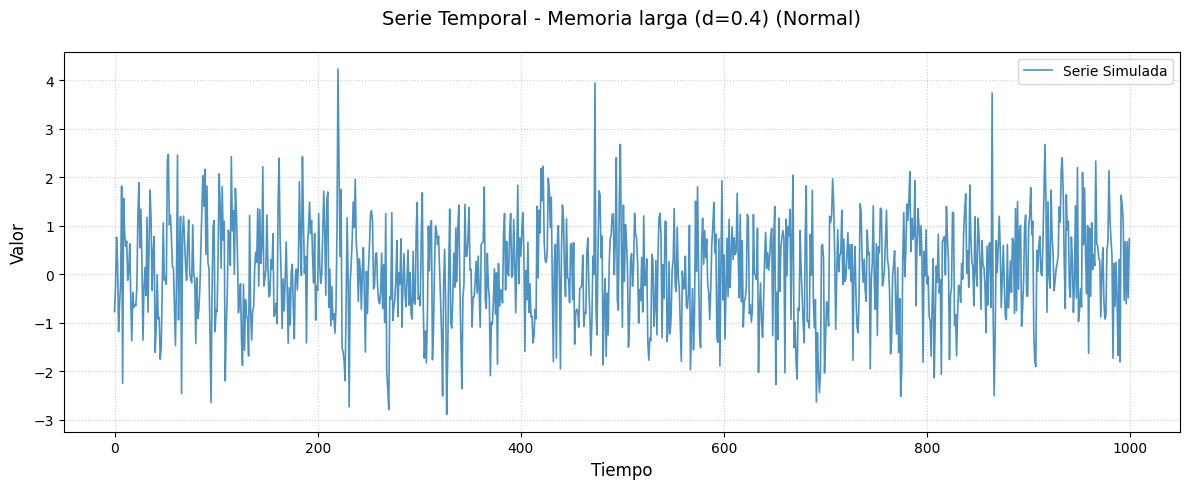

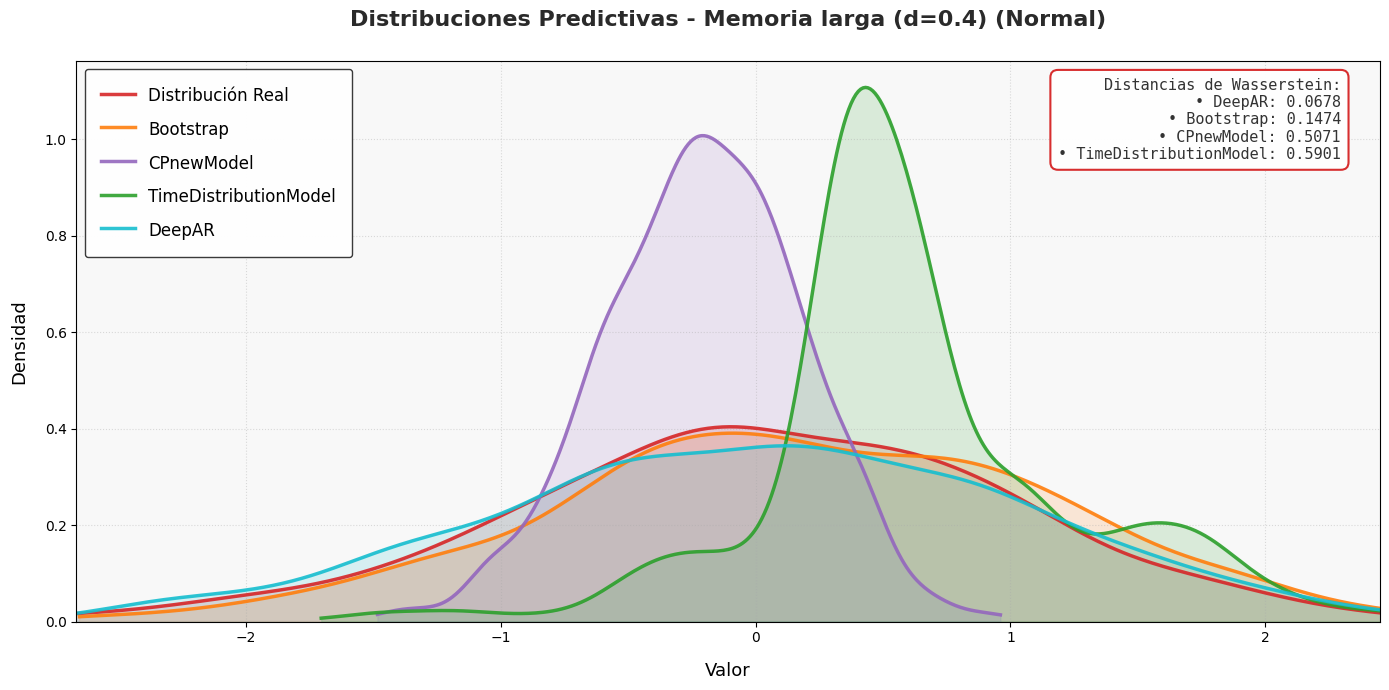


══════════════════════════════════════════════════
Hiperparámetros Óptimos:


n_lags       rho  poly_degree  hidden_size  num_layers  \
Modelo                                                                          
Bootstrap                   3       NaN          NaN          NaN         NaN   
CPnewModel                  8  0.948707          3.0          NaN         NaN   
TimeDistributionModel       1  0.608889          NaN          NaN         NaN   
DeepAR                      6       NaN          NaN          6.0         2.0   

                        dropout        lr  
Modelo                                     
Bootstrap                   NaN       NaN  
CPnewModel                  NaN       NaN  
TimeDistributionModel       NaN       NaN  
DeepAR                 0.077997  0.086751


══════════════════════════════════════════════════
Métricas de Desempeño:



##################################################
Ejecutando: Memoria antipersistente (d=-0.3)
##################################################

============================== Bootstrap ==============================
✅ Mejor n_lags encontrado: 3 (Wasserstein = 0.1155)

============================== CPnewModel ==============================
✅ Optimización exitosa:
  • Lags: 8
  • Rho: 0.949
  • Grado polinomial: 3
  • Distancia de Wasserstein: 0.5071

============================== TimeDistributionModel ==============================
Mejora encontrada: (1, np.float64(0.5)) - 0.6409
Mejora encontrada: (1, np.float64(0.5544444444444444)) - 0.6260
Mejora encontrada: (1, np.float64(0.6088888888888889)) - 0.5731
✅ Optimización final: n_lags=1, rho=0.609
Distancia de Wasserstein: 0.5731

============================== DeepAR ==============================
✅ Optimización DeepAR Exitosa:
  • Lags: 6
  • Hidden Size: 6
  • Capas LSTM: 2
  • Dropout: 0.078
  • Learning Rate: 0.0868


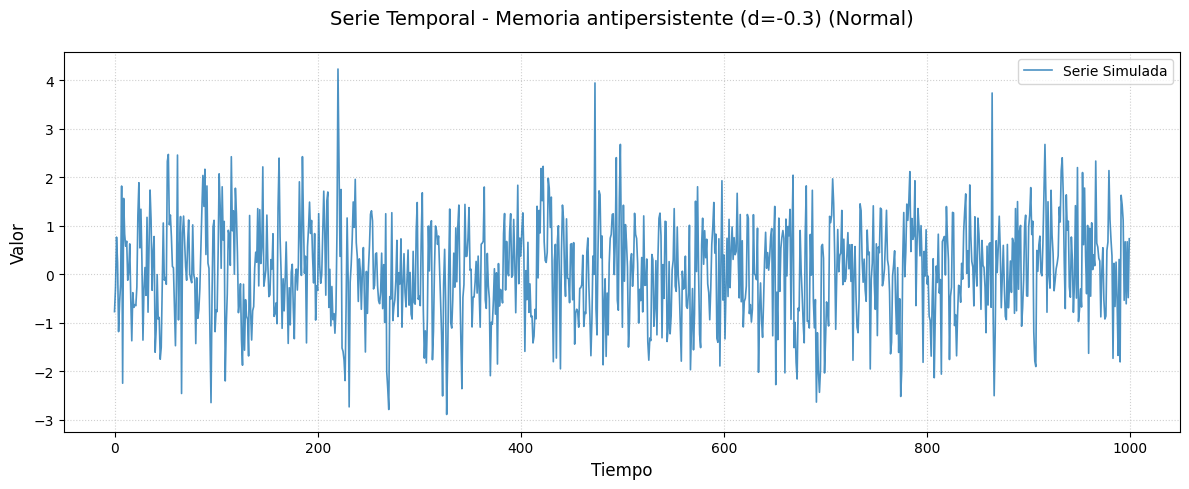

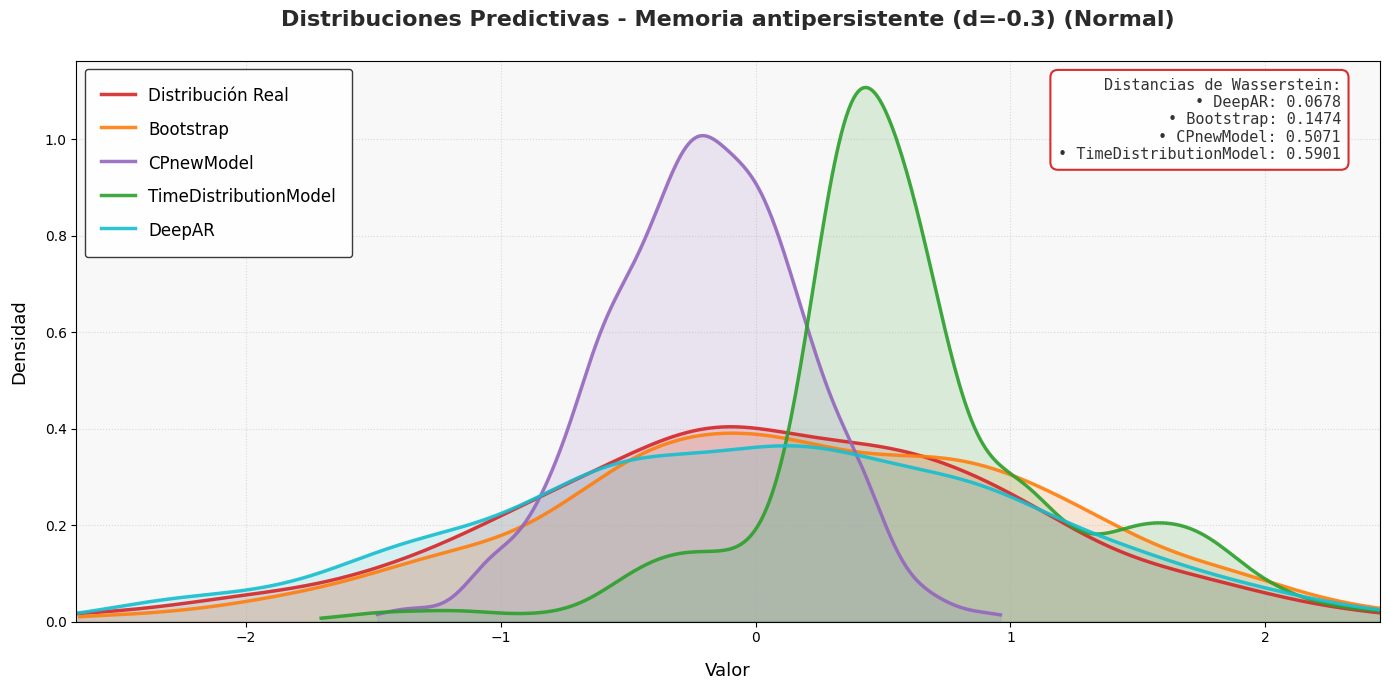


══════════════════════════════════════════════════
Hiperparámetros Óptimos:


n_lags       rho  poly_degree  hidden_size  num_layers  \
Modelo                                                                          
Bootstrap                   3       NaN          NaN          NaN         NaN   
CPnewModel                  8  0.948707          3.0          NaN         NaN   
TimeDistributionModel       1  0.608889          NaN          NaN         NaN   
DeepAR                      6       NaN          NaN          6.0         2.0   

                        dropout        lr  
Modelo                                     
Bootstrap                   NaN       NaN  
CPnewModel                  NaN       NaN  
TimeDistributionModel       NaN       NaN  
DeepAR                 0.077997  0.086751


══════════════════════════════════════════════════
Métricas de Desempeño:



##################################################
Ejecutando: Outliers moderados (5%)
##################################################

============================== Bootstrap ==============================
✅ Mejor n_lags encontrado: 1 (Wasserstein = 0.2803)

============================== CPnewModel ==============================
✅ Optimización exitosa:
  • Lags: 8
  • Rho: 0.973
  • Grado polinomial: 3
  • Distancia de Wasserstein: 0.1549

============================== TimeDistributionModel ==============================
Mejora encontrada: (1, np.float64(0.5)) - 1.0949
Mejora encontrada: (1, np.float64(0.6633333333333333)) - 1.0851
Mejora encontrada: (1, np.float64(0.7177777777777777)) - 1.0839
Mejora encontrada: (1, np.float64(0.7722222222222221)) - 1.0713
Mejora encontrada: (1, np.float64(0.9355555555555555)) - 1.0670
Mejora encontrada: (1, np.float64(0.99)) - 1.0501
Mejora encontrada: (11, np.float64(0.5544444444444444)) - 1.0336
Mejora encontrada: (11, np.float64(0.99)) - 1

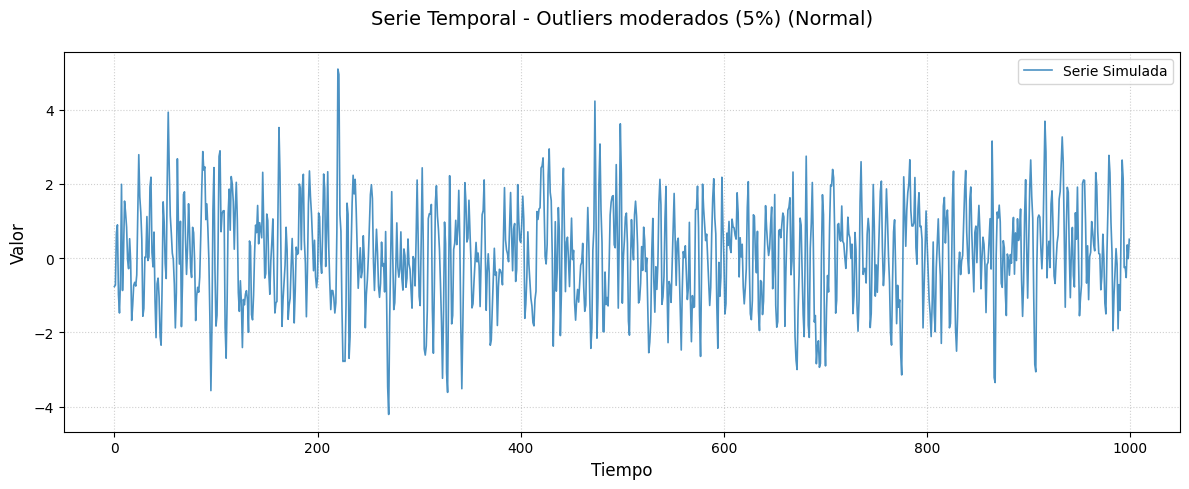

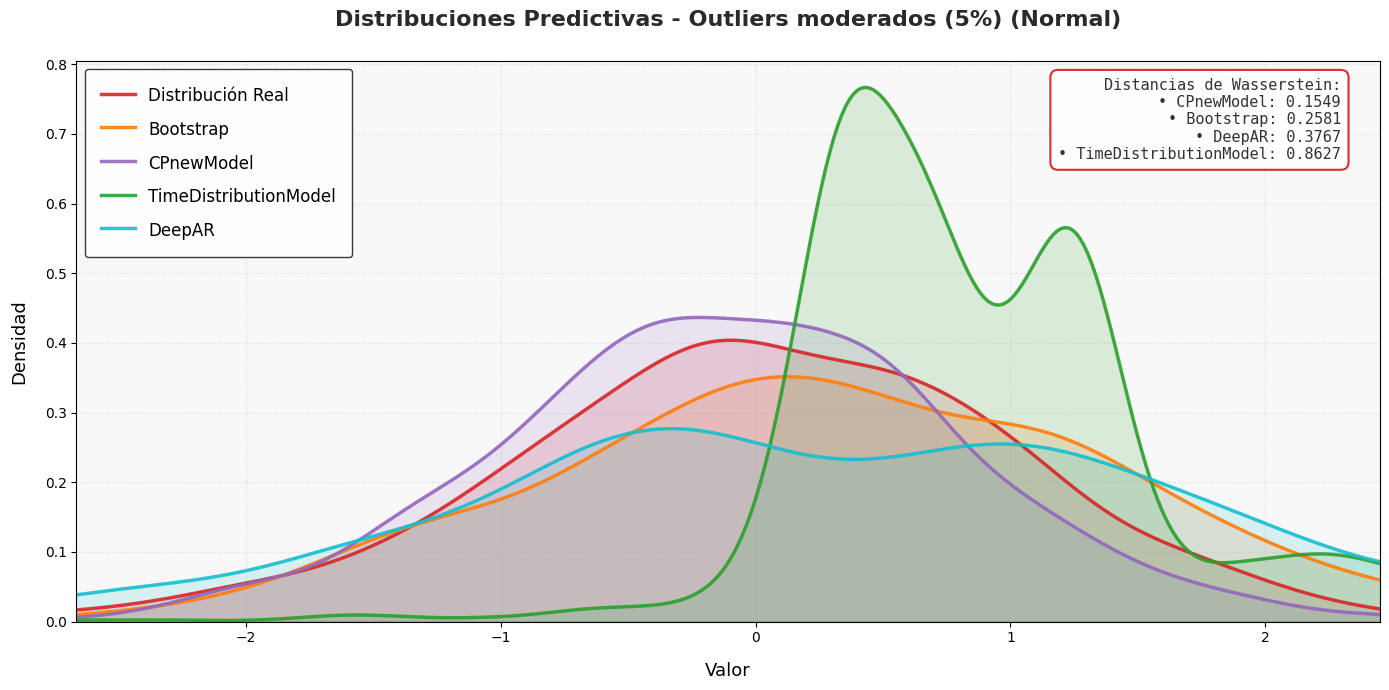


══════════════════════════════════════════════════
Hiperparámetros Óptimos:


n_lags       rho  poly_degree  hidden_size  num_layers  \
Modelo                                                                          
Bootstrap                   1       NaN          NaN          NaN         NaN   
CPnewModel                  8  0.972508          3.0          NaN         NaN   
TimeDistributionModel      12  0.500000          NaN          NaN         NaN   
DeepAR                      1       NaN          NaN          6.0         1.0   

                        dropout        lr  
Modelo                                     
Bootstrap                   NaN       NaN  
CPnewModel                  NaN       NaN  
TimeDistributionModel       NaN       NaN  
DeepAR                 0.292002  0.004545


══════════════════════════════════════════════════
Métricas de Desempeño:



##################################################
Ejecutando: Outliers masivos (20%)
##################################################

============================== Bootstrap ==============================
✅ Mejor n_lags encontrado: 1 (Wasserstein = 0.2803)

============================== CPnewModel ==============================
✅ Optimización exitosa:
  • Lags: 8
  • Rho: 0.973
  • Grado polinomial: 3
  • Distancia de Wasserstein: 0.1549

============================== TimeDistributionModel ==============================
Mejora encontrada: (1, np.float64(0.5)) - 1.0949
Mejora encontrada: (1, np.float64(0.6633333333333333)) - 1.0851
Mejora encontrada: (1, np.float64(0.7177777777777777)) - 1.0839
Mejora encontrada: (1, np.float64(0.7722222222222221)) - 1.0713
Mejora encontrada: (1, np.float64(0.9355555555555555)) - 1.0670
Mejora encontrada: (1, np.float64(0.99)) - 1.0501
Mejora encontrada: (11, np.float64(0.5544444444444444)) - 1.0336
Mejora encontrada: (11, np.float64(0.99)) - 1.

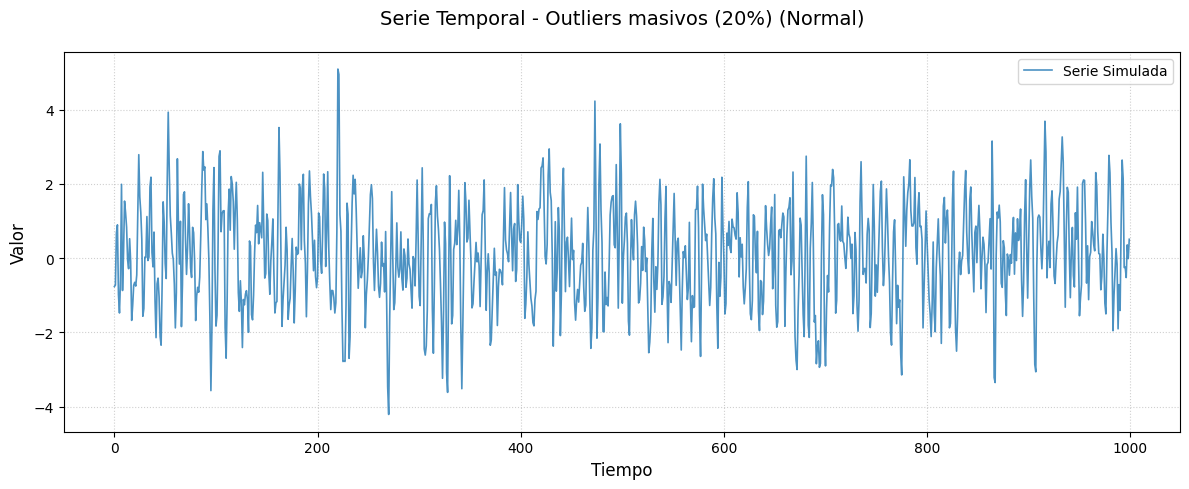

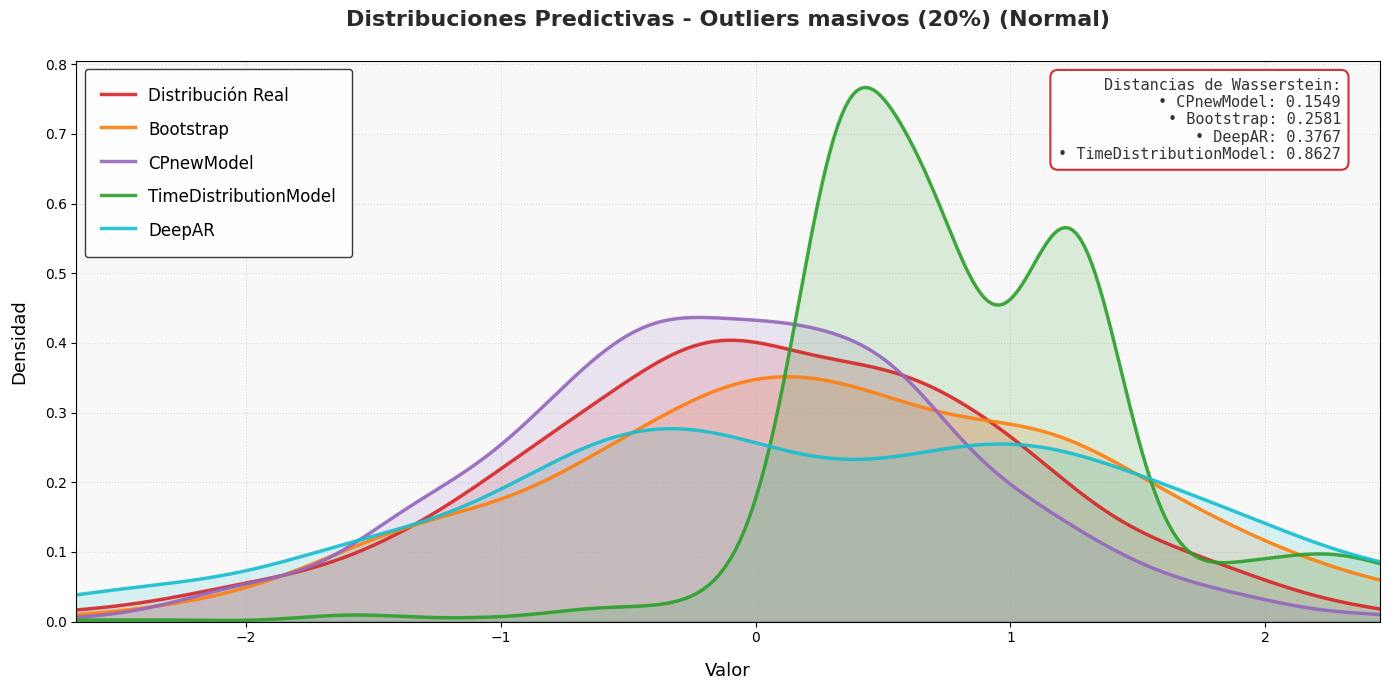


══════════════════════════════════════════════════
Hiperparámetros Óptimos:


n_lags       rho  poly_degree  hidden_size  num_layers  \
Modelo                                                                          
Bootstrap                   1       NaN          NaN          NaN         NaN   
CPnewModel                  8  0.972508          3.0          NaN         NaN   
TimeDistributionModel      12  0.500000          NaN          NaN         NaN   
DeepAR                      1       NaN          NaN          6.0         1.0   

                        dropout        lr  
Modelo                                     
Bootstrap                   NaN       NaN  
CPnewModel                  NaN       NaN  
TimeDistributionModel       NaN       NaN  
DeepAR                 0.292002  0.004545


══════════════════════════════════════════════════
Métricas de Desempeño:



##################################################
Ejecutando: Estrés hipervolátil (σ=5.0)
##################################################

============================== Bootstrap ==============================
✅ Mejor n_lags encontrado: 1 (Wasserstein = 5.3302)

============================== CPnewModel ==============================
✅ Optimización exitosa:
  • Lags: 1
  • Rho: 0.703
  • Grado polinomial: 2
  • Distancia de Wasserstein: 1.6629

============================== TimeDistributionModel ==============================
Mejora encontrada: (1, np.float64(0.5)) - 14.2040
Mejora encontrada: (1, np.float64(0.6088888888888889)) - 12.8752
Mejora encontrada: (1, np.float64(0.99)) - 12.7467
✅ Optimización final: n_lags=1, rho=0.990
Distancia de Wasserstein: 12.7467

============================== DeepAR ==============================
✅ Optimización DeepAR Exitosa:
  • Lags: 3
  • Hidden Size: 9
  • Capas LSTM: 2
  • Dropout: 0.404
  • Learning Rate: 0.0324


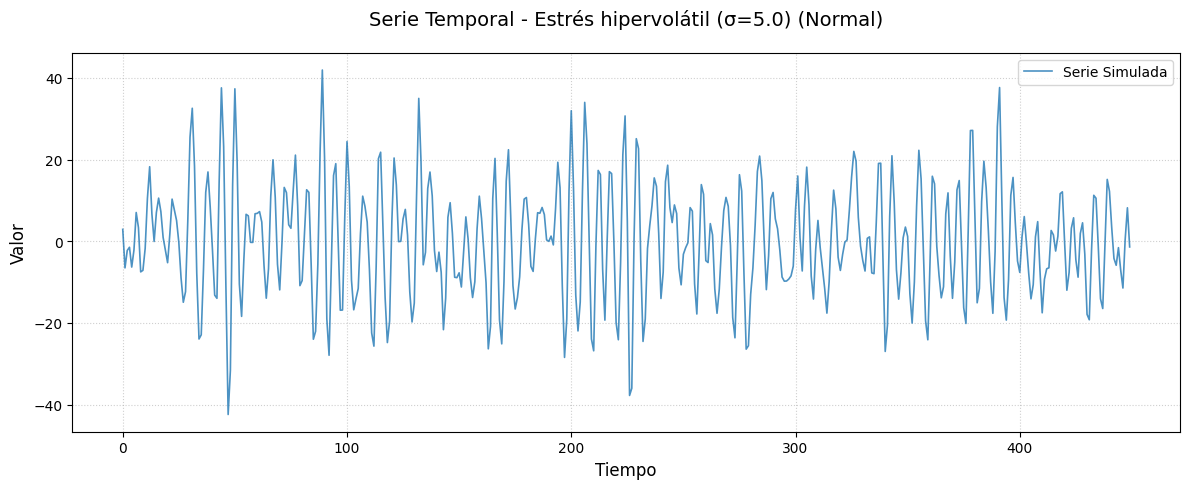

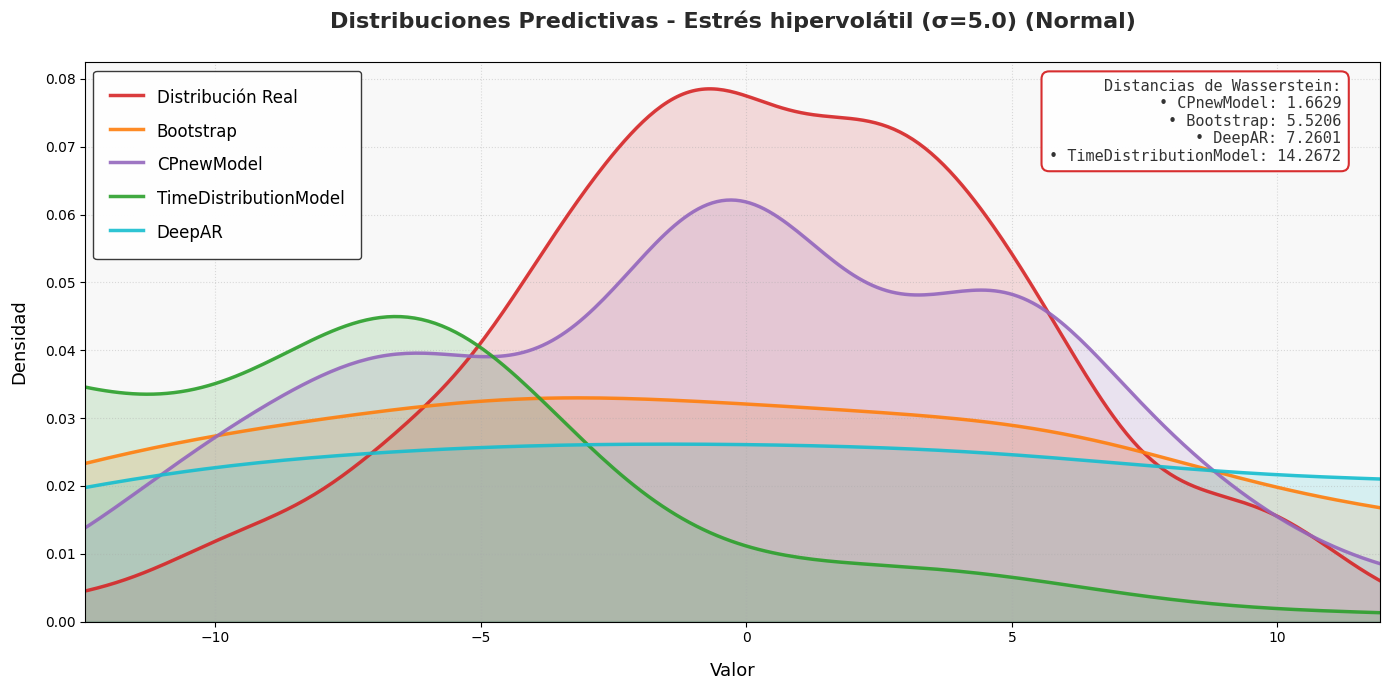


══════════════════════════════════════════════════
Hiperparámetros Óptimos:


n_lags       rho  poly_degree  hidden_size  num_layers  \
Modelo                                                                          
Bootstrap                   1       NaN          NaN          NaN         NaN   
CPnewModel                  1  0.702576          2.0          NaN         NaN   
TimeDistributionModel       1  0.990000          NaN          NaN         NaN   
DeepAR                      3       NaN          NaN          9.0         2.0   

                        dropout        lr  
Modelo                                     
Bootstrap                   NaN       NaN  
CPnewModel                  NaN       NaN  
TimeDistributionModel       NaN       NaN  
DeepAR                 0.403775  0.032356


══════════════════════════════════════════════════
Métricas de Desempeño:



##################################################
Ejecutando: Estrés de raíz unitaria (φ=0.99)
##################################################

============================== Bootstrap ==============================
✅ Mejor n_lags encontrado: 1 (Wasserstein = 3.0878)

============================== CPnewModel ==============================
✅ Optimización exitosa:
  • Lags: 1
  • Rho: 0.730
  • Grado polinomial: 3
  • Distancia de Wasserstein: 2.7896

============================== TimeDistributionModel ==============================
Mejora encontrada: (1, np.float64(0.5)) - 1.7179
Mejora encontrada: (1, np.float64(0.5544444444444444)) - 1.7050
Mejora encontrada: (1, np.float64(0.8811111111111111)) - 1.7008
✅ Optimización final: n_lags=1, rho=0.881
Distancia de Wasserstein: 1.7008

============================== DeepAR ==============================
✅ Optimización DeepAR Exitosa:
  • Lags: 6
  • Hidden Size: 6
  • Capas LSTM: 2
  • Dropout: 0.444
  • Learning Rate: 0.0489


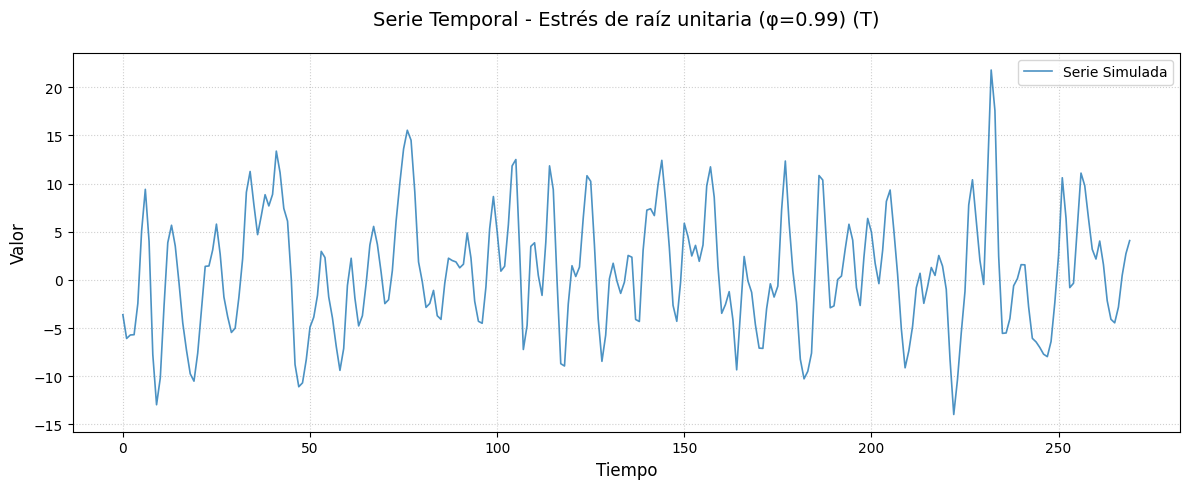

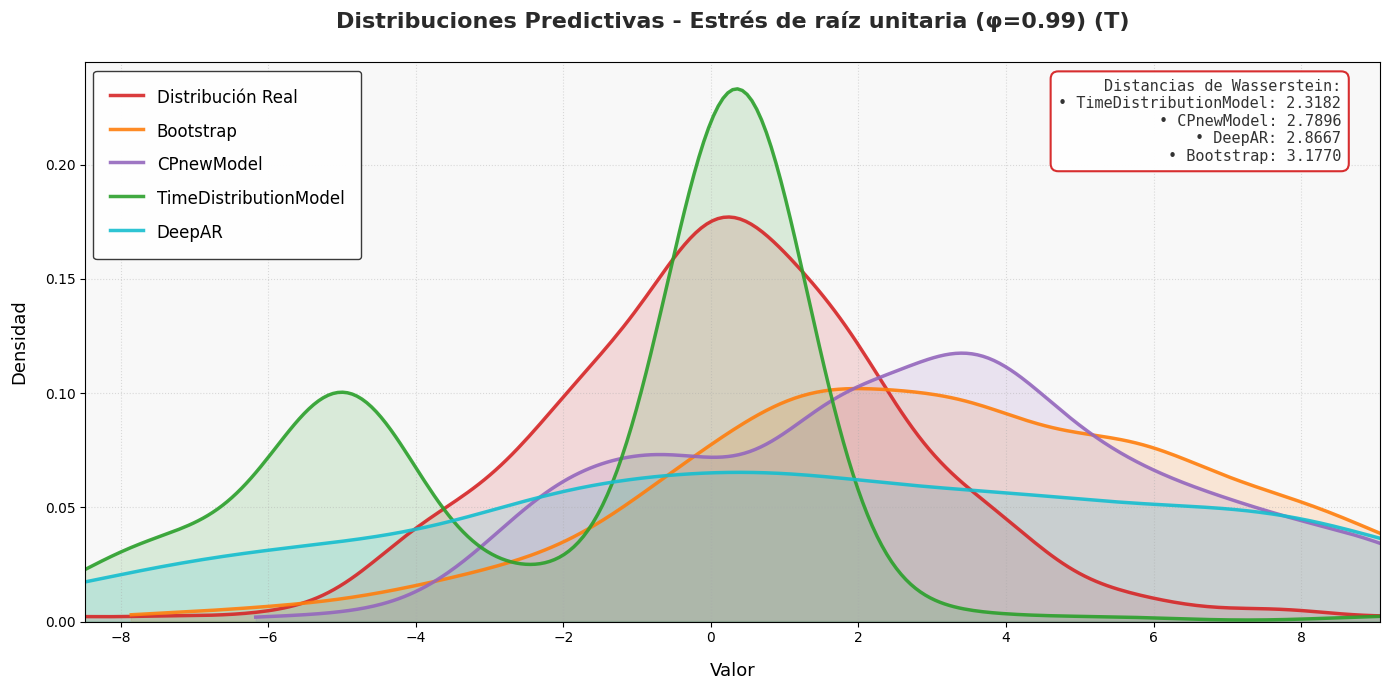


══════════════════════════════════════════════════
Hiperparámetros Óptimos:


n_lags       rho  poly_degree  hidden_size  num_layers  \
Modelo                                                                          
Bootstrap                   1       NaN          NaN          NaN         NaN   
CPnewModel                  1  0.730442          3.0          NaN         NaN   
TimeDistributionModel       1  0.881111          NaN          NaN         NaN   
DeepAR                      6       NaN          NaN          6.0         2.0   

                        dropout        lr  
Modelo                                     
Bootstrap                   NaN       NaN  
CPnewModel                  NaN       NaN  
TimeDistributionModel       NaN       NaN  
DeepAR                 0.444491  0.048896


══════════════════════════════════════════════════
Métricas de Desempeño:



##################################################
Ejecutando: Estrés de serie mínima (n=50)
##################################################

============================== Bootstrap ==============================
✅ Mejor n_lags encontrado: 1 (Wasserstein = 2.2539)

============================== CPnewModel ==============================
✅ Optimización exitosa:
  • Lags: 2
  • Rho: 0.733
  • Grado polinomial: 1
  • Distancia de Wasserstein: 0.3602

============================== TimeDistributionModel ==============================
Mejora encontrada: (1, np.float64(0.5)) - 0.4816
Mejora encontrada: (1, np.float64(0.5544444444444444)) - 0.4128
Mejora encontrada: (1, np.float64(0.6633333333333333)) - 0.3943
Mejora encontrada: (1, np.float64(0.7722222222222221)) - 0.3336
✅ Optimización final: n_lags=1, rho=0.772
Distancia de Wasserstein: 0.3336

============================== DeepAR ==============================
✅ Optimización DeepAR Exitosa:
  • Lags: 3
  • Hidden Size: 29
  • Capas 

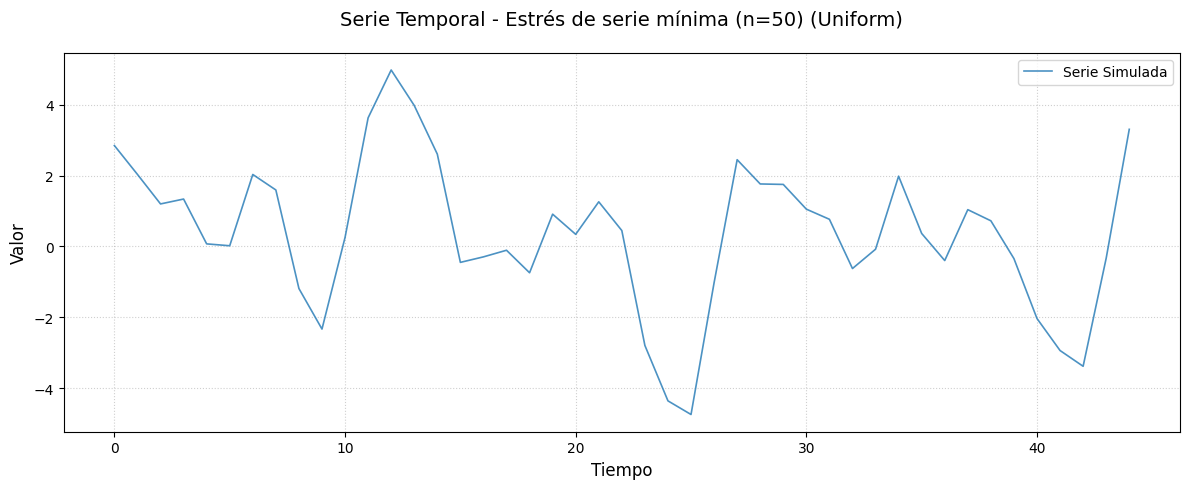

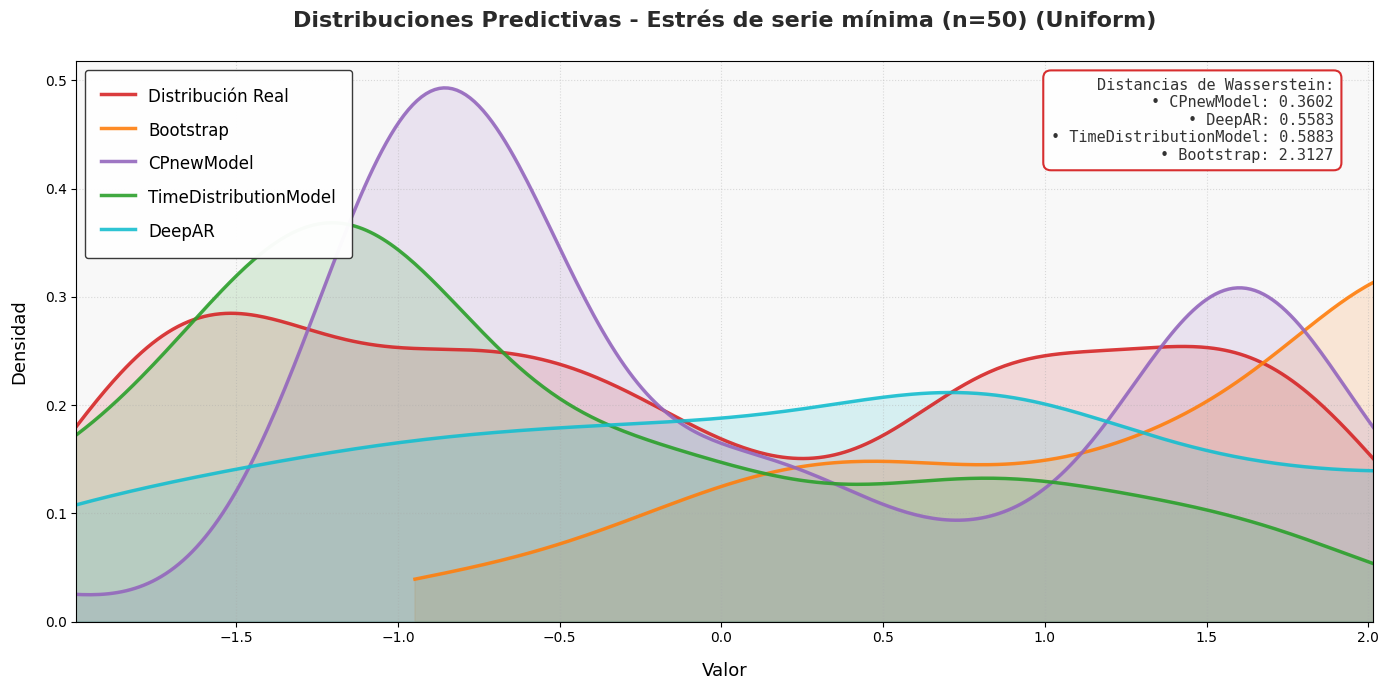


══════════════════════════════════════════════════
Hiperparámetros Óptimos:


n_lags       rho  poly_degree  hidden_size  num_layers  \
Modelo                                                                          
Bootstrap                   1       NaN          NaN          NaN         NaN   
CPnewModel                  2  0.732586          1.0          NaN         NaN   
TimeDistributionModel       1  0.772222          NaN          NaN         NaN   
DeepAR                      3       NaN          NaN         29.0         2.0   

                        dropout        lr  
Modelo                                     
Bootstrap                   NaN       NaN  
CPnewModel                  NaN       NaN  
TimeDistributionModel       NaN       NaN  
DeepAR                 0.134407  0.051925


══════════════════════════════════════════════════
Métricas de Desempeño:



##################################################
Ejecutando: Estrés de outliers masivos (30%)
##################################################

============================== Bootstrap ==============================
✅ Mejor n_lags encontrado: 1 (Wasserstein = 0.2910)

============================== CPnewModel ==============================
✅ Optimización exitosa:
  • Lags: 2
  • Rho: 0.852
  • Grado polinomial: 2
  • Distancia de Wasserstein: 0.1000

============================== TimeDistributionModel ==============================
Mejora encontrada: (1, np.float64(0.5)) - 0.9588
Mejora encontrada: (1, np.float64(0.6088888888888889)) - 0.9557
Mejora encontrada: (2, np.float64(0.5)) - 0.8336
Mejora encontrada: (2, np.float64(0.6088888888888889)) - 0.8031
Mejora encontrada: (6, np.float64(0.5)) - 0.7928
Mejora encontrada: (6, np.float64(0.5544444444444444)) - 0.7783
Mejora encontrada: (7, np.float64(0.5)) - 0.7178
✅ Optimización final: n_lags=7, rho=0.500
Distancia de Wasserstein: 

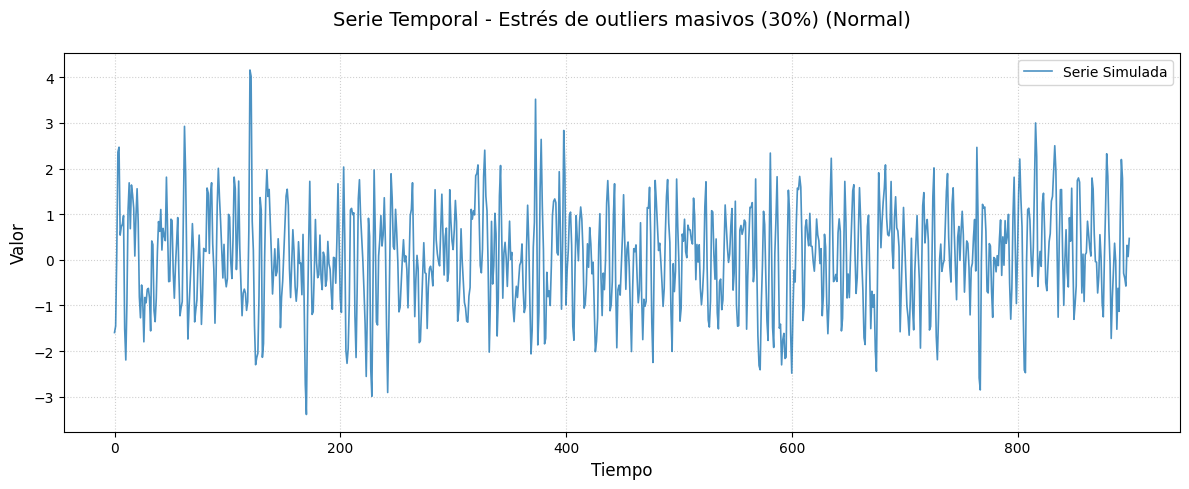

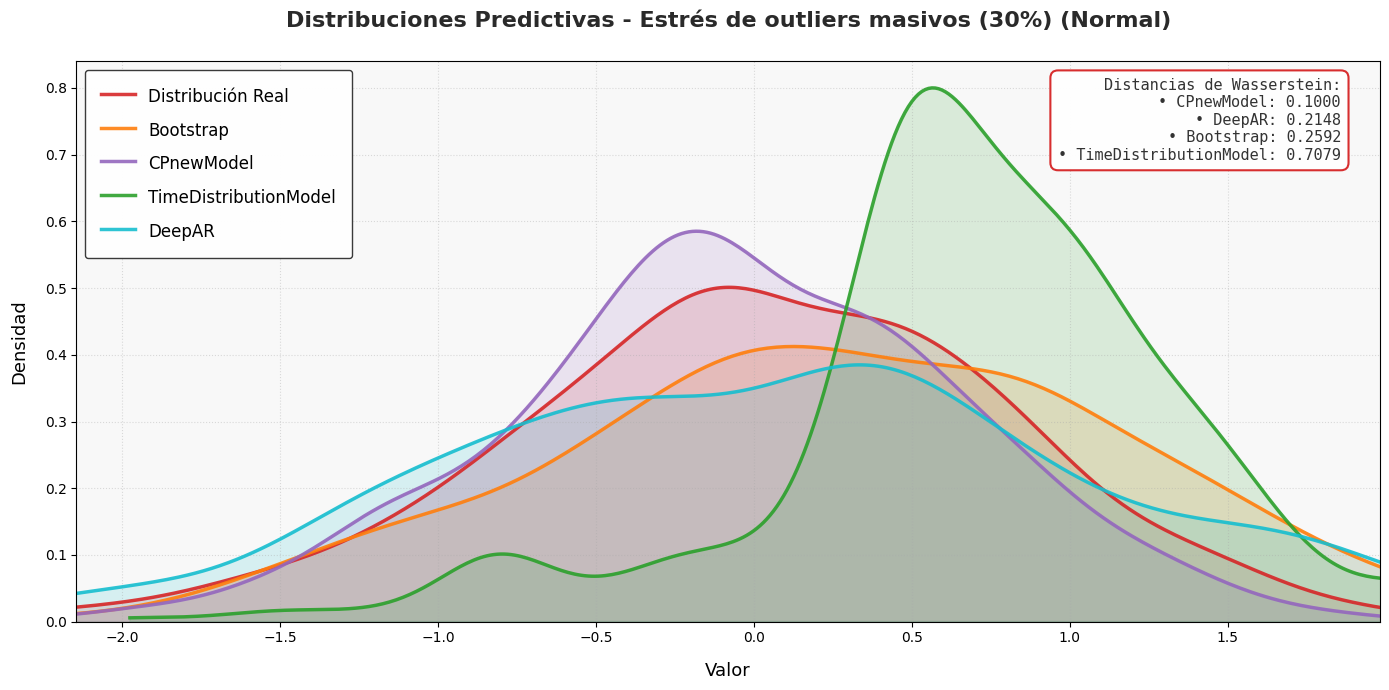


══════════════════════════════════════════════════
Hiperparámetros Óptimos:


n_lags       rho  poly_degree  hidden_size  num_layers  \
Modelo                                                                          
Bootstrap                   1       NaN          NaN          NaN         NaN   
CPnewModel                  2  0.852179          2.0          NaN         NaN   
TimeDistributionModel       7  0.500000          NaN          NaN         NaN   
DeepAR                      6       NaN          NaN         28.0         1.0   

                        dropout        lr  
Modelo                                     
Bootstrap                   NaN       NaN  
CPnewModel                  NaN       NaN  
TimeDistributionModel       NaN       NaN  
DeepAR                 0.260965  0.060786


══════════════════════════════════════════════════
Métricas de Desempeño:



##################################################
Ejecutando: Estrés multimodal (mezcla gaussiana)
##################################################
Error en Estrés multimodal (mezcla gaussiana): Distribución no soportada


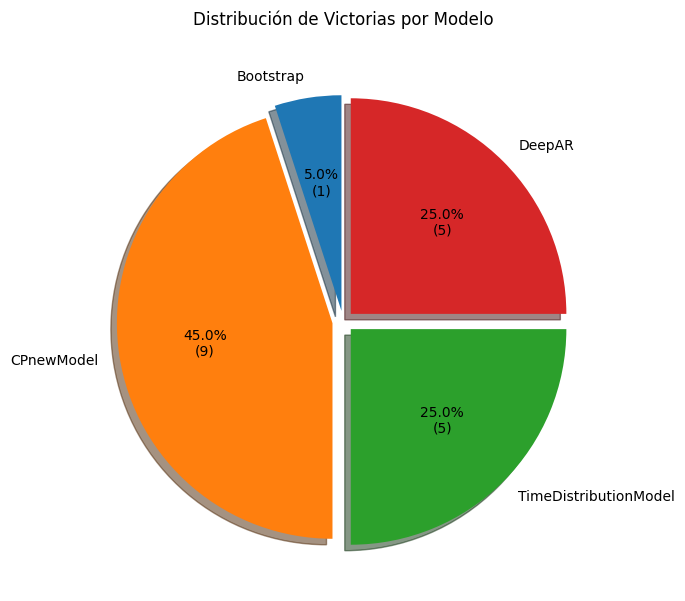


══════════════════════════════════════════════════
Resultados por Escenario:


Escenario  Wasserstein Bootstrap  \
0                       Ruido normal               0.143946   
1                      Ruido uniform               0.199331   
2                            Ruido t               0.050129   
3                  Ruido exponential               0.131624   
4              Estacionalidad diaria               0.244862   
5               Estacionalidad anual               0.244862   
6            Estacionalidad compleja               0.244862   
7           Umbral no lineal (Z=0.5)               0.258148   
8         Transformación logarítmica               0.258148   
9                  Componente cúbico               0.258148   
10      Volatilidad moderada (GARCH)               0.374714   
11     Volatilidad explosiva (GARCH)               0.374714   
12             Memoria larga (d=0.4)               0.147354   
13  Memoria antipersistente (d=-0.3)               0.147354   
14           Outliers moderados (5%)               0.258148   
15            Outliers masivos (20%)               0.258148   
16       Estrés hipervolátil (σ=5.0)               5.520574   
17  Estrés de raíz unitaria (φ=0.99)               3.176994   
18     Estrés de serie mínima (n=50)               2.312661   
19  Estrés de outliers masivos (30%)               0.259178   

    Wasserstein CPnewModel  Wasserstein TimeDistributionModel  \
0                 0.092470                           0.438771   
1                 0.742647                           0.109643   
2                 0.821261                           0.253053   
3                 0.308213                           0.125758   
4                 0.286654                           0.494375   
5                 0.286654                           0.494375   
6                 0.286654                           0.494375   
7                 0.154881                           0.862666   
8                 0.154881                           0.862666   
9                 0.154881                           0.862666   
10                0.421313                           0.190227   
11                0.421313                           0.190227   
12                0.507062                           0.590069   
13                0.507062                           0.590069   
14                0.154881                           0.862666   
15                0.154881                           0.862666   
16                1.662869                          14.267218   
17                2.789644                           2.318194   
18                0.360213                           0.588343   
19                0.099993                           0.707913   

    Wasserstein DeepAR           Mejor modelo  
0             0.136728             CPnewModel  
1             0.144523  TimeDistributionModel  
2             0.393435              Bootstrap  
3             0.160903  TimeDistributionModel  
4             0.223285                 DeepAR  
5             0.223285                 DeepAR  
6             0.223285                 DeepAR  
7             0.376733             CPnewModel  
8             0.376733             CPnewModel  
9             0.376733             CPnewModel  
10            0.407926  TimeDistributionModel  
11            0.407926  TimeDistributionModel  
12            0.067766                 DeepAR  
13            0.067766                 DeepAR  
14            0.376733             CPnewModel  
15            0.376733             CPnewModel  
16            7.260138             CPnewModel  
17            2.866697  TimeDistributionModel  
18            0.558340             CPnewModel  
19            0.214769             CPnewModel


══════════════════════════════════════════════════
Estadísticas por Modelo:


Modelo  Victorias  Wasserstein Promedio  Wasserstein Mediana
1             CPnewModel          9              0.518421             0.297433
2  TimeDistributionModel          5              1.308297             0.589206
3                 DeepAR          5              0.762022             0.376733
0              Bootstrap          1              0.743195             0.258148


══════════════════════════════════════════════════
Análisis Comparativo Detallado


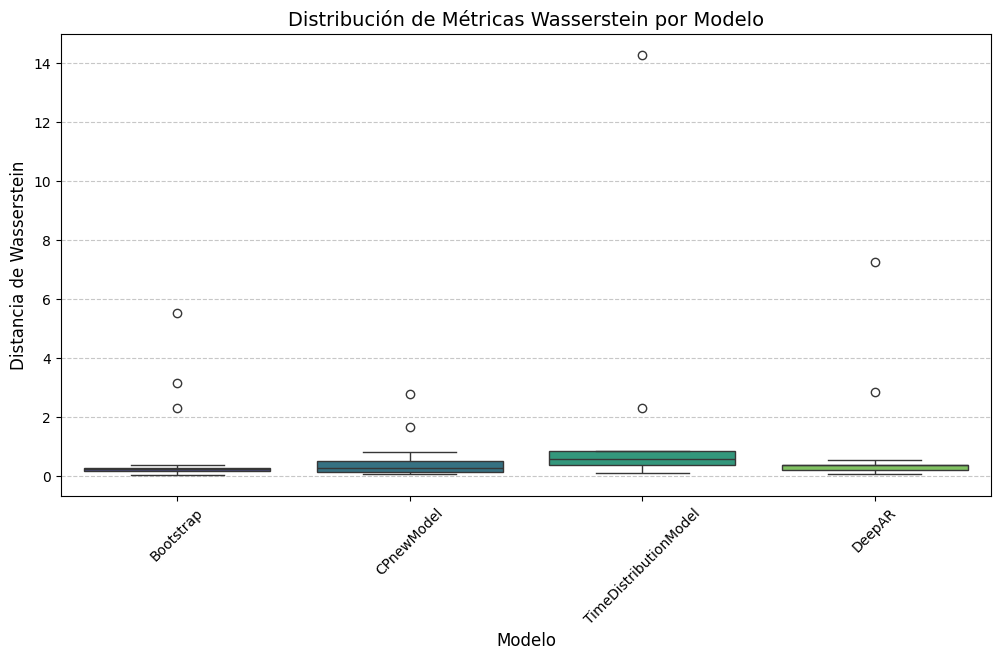


══════════════════════════════════════════════════
Pruebas Estadísticas (t-test pareado)

CPnewModel vs TimeDistributionModel:
t = -1.254, p = 0.22490

CPnewModel vs Bootstrap:
t = -1.002, p = 0.32871

TimeDistributionModel vs DeepAR:
t = 1.573, p = 0.13223

TimeDistributionModel vs Bootstrap:
t = 1.258, p = 0.22352


In [79]:
if __name__ == "__main__":
    # Ejecutar todos los escenarios
    runner = ScenarioRunner().run()
    
    # Mostrar resultados básicos
    print("\n" + "═"*50)
    print("Resultados por Escenario:")
    display(runner.get_scenario_results())
    
    print("\n" + "═"*50)
    print("Estadísticas por Modelo:")
    display(runner.get_model_stats())

    # --------------------------------------------
    # Nuevo análisis comparativo (agregar desde aquí)
    # --------------------------------------------
    
    print("\n" + "═"*50)
    print("Análisis Comparativo Detallado")
    
    # 1. Gráfico de cajas comparativo
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    plt.figure(figsize=(12, 6))
    metrics_df = runner.get_scenario_results().filter(regex='Wasserstein|Escenario')
    melted_df = pd.melt(metrics_df, id_vars=['Escenario'], 
                        var_name='Modelo', value_name='Wasserstein')
    
    # Filtrar modelos a comparar
    modelos_comparar = ['CPnewModel', 'TimeDistributionModel', 'Bootstrap', 'DeepAR']
    melted_df['Modelo'] = melted_df['Modelo'].str.replace('Wasserstein ', '')
    melted_df = melted_df[melted_df['Modelo'].isin(modelos_comparar)]
    
    sns.boxplot(x='Modelo', y='Wasserstein', data=melted_df, palette='viridis')
    plt.title('Distribución de Métricas Wasserstein por Modelo', fontsize=14)
    plt.xlabel('Modelo', fontsize=12)
    plt.ylabel('Distancia de Wasserstein', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # 2. Pruebas de hipótesis
    from scipy.stats import ttest_rel
    
    print("\n" + "═"*50)
    print("Pruebas Estadísticas (t-test pareado)")
    
    df = runner.get_scenario_results()
    
    # Comparación 1: CPnewModel vs TimeDistributionModel
    t_stat, p_value = ttest_rel(df['Wasserstein CPnewModel'], 
                                 df['Wasserstein TimeDistributionModel'])
    print(f"\nCPnewModel vs TimeDistributionModel:")
    print(f"t = {t_stat:.3f}, p = {p_value:.5f}")
    if p_value < 0.05:
        print("Diferencia estadísticamente significativa (p < 0.05)")
    
    # Comparación 2: CPnewModel vs Bootstrap
    t_stat, p_value = ttest_rel(df['Wasserstein CPnewModel'], 
                                 df['Wasserstein Bootstrap'])
    print(f"\nCPnewModel vs Bootstrap:")
    print(f"t = {t_stat:.3f}, p = {p_value:.5f}")
    if p_value < 0.05:
        print("Diferencia estadísticamente significativa (p < 0.05)")
    
    # Comparación 3: TimeDistributionModel vs DeepAR
    t_stat, p_value = ttest_rel(df['Wasserstein TimeDistributionModel'], 
                                 df['Wasserstein DeepAR'])
    print(f"\nTimeDistributionModel vs DeepAR:")
    print(f"t = {t_stat:.3f}, p = {p_value:.5f}")
    if p_value < 0.05:
        print("Diferencia estadísticamente significativa (p < 0.05)")

    # Comparación 4:  TimeDistributionModel vs Bootstrap
    t_stat, p_value = ttest_rel(df['Wasserstein TimeDistributionModel'], 
                                 df['Wasserstein Bootstrap'])
    print(f"\nTimeDistributionModel vs Bootstrap:")
    print(f"t = {t_stat:.3f}, p = {p_value:.5f}")
    if p_value < 0.05:
        print("Diferencia estadísticamente significativa (p < 0.05)")